# Overview of integration of INformation laters

![Spatial layers integration](./img/spatial_layers_integration.jpg)

In [ ]:
import os
import pandas as pd
import geopandas as gpd
import python.mod_01_0_wb_automator as wb_automator
import python.mod_01_1_pivot_rooftop_data as pivot_rt_analysis
import python.mod_02_pv_power_month as pv_rt_analysis
import python.mod_03_geopandas_facade_analyser as facade_analyser
import python.mod_04_1_ener_consum_profile_assigner as ener_cons_profile_assigner
import python.mod_04_2_energy_profile_aggregation as profile_aggregation
import python.mod_04_3_self_consump_estimation as self_cons_estimator
import python.mod_05_0_inspire_db_assigner as inspire_db_assigner
import python.mod_05_1_simple_kpi_calc as kpi_calc
import python.mod_05_2_economic_analysis as economic_analysis
import python.mod_06_enercom_estimator as enercom_estimator
import python.mod_07_self_cons_scenarios_calc as self_cons_scenarios_calc 
import python.mod_07_geo_visualization as geo_visualization
import python.util_func as util_func

In [ ]:
# Class to extract file names form the excel file
class DefaultPathsAndFileNames:
    """
    A class to hold a set of default paths for a standardized and replicable approach.
    """

    def __init__(self, excel_path='files_directories_naming.xlsx', sheet_name="Sheet1"):
        """
        Initialize the DefaultPaths class.

        Args:
            excel_path (str, optional): Path to the Excel file containing variable names.
            sheet_name (str, optional): Name of the sheet to read from the Excel file.
        
        self.BASE_DIR = "your_custom_name"  # Replace with your base directory
        self.data_dir = f"{self.BASE_DIR}/data"
        self.lidar_dir = f"{self.BASE_DIR}/lidar"
        self.vector_dir = f"{self.BASE_DIR}/vector"
        self.raster_dir = f"{self.BASE_DIR}/raster"

        # Define file names
        self.LIDAR_FILE = "lidar.las"
        self.BUILDING_FOOTPRINT_FILE = "building_footprint.shp"
        self.STATISTICAL_CENSUS_FILE = "statistical_census.shp"
        self.WHITEBOX_RT_ANALYSIS_FILE = "wb_rt_analysis.shp"
        """
        # Extract file names from Excel and set them as attributes
        if excel_path and sheet_name:
            df=self._set_file_names_from_excel(excel_path, sheet_name)
            print(df)
            self.PATH = os.getcwd() if pd.isna(df.loc['PATH', 'Name']) else f"{df.loc['PATH', 'Name']}"
            self.LIDAR_FILE = f"{df.loc['LIDAR_FILE', 'Name']}"
            self.BUILDING_FOOTPRINT_FILE = f"{df.loc['BUILDING_FOOTPRINT_FILE','Name']}"
            self.STATISTICAL_CENSUS_FILE = f"{df.loc['STATISTICAL_CENSUS_FILE','Name']}"
            self.HEATMAPS_HDEM_RASTER = f"{df.loc['HEATMAPS_HDEM_RASTER','Name']}" if 'HEATMAPS_HDEM_RASTER' in df.index else None
            self.WHITEBOX_RT_ANALYSIS_FILE = f"{df.loc['WHITEBOX_RT_ANALYSIS_FILE','Name']}"
            self.LPG_FILES_DIR = f"{df.loc['LPG_FILES_DIR','Name']}" if 'LPG_FILES_DIR' in df.index else "LoadProGen"
            self.ROOFTOP_FILE = f"{df.loc['ROOFTOP_FILE','Name']}" if 'ROOFTOP_FILE' in df.index else None
            self.SEGMENT_FILE = f"{df.loc['SEGMENT_FILE','Name']}" if 'SEGMENT_FILE' in df.index else None

            #Print the file names for demonstration
            #print("File names from Excel:\n")
            #print(f"PATH: {self.PATH}")
            #print(f"LIDAR_FILE: {self.LIDAR_FILE}")
            #print(f"BUILDING_FOOTPRINT_FILE: {self.BUILDING_FOOTPRINT_FILE}")
            #print(f"STATISTICAL_CENSUS_FILE: {self.STATISTICAL_CENSUS_FILE}")
            #print(f"WHITEBOX_RT_ANALYSIS_FILE: {self.WHITEBOX_RT_ANALYSIS_FILE}")

    def get(self, key):
        """
        Retrieve the path associated with a given key.

        Args:
            key (str): The key for the desired path.

        Returns:
            str: The corresponding path, or None if the key does not exist.
        """
        return getattr(self, key, None)

    def _set_file_names_from_excel(self, excel_path, sheet_name):
        """
        Extract file names from an Excel sheet and set them as attributes.

        Args:
            excel_path (str): Path to the Excel file.
            sheet_name (str): Name of the sheet to read.
        """
        try:
            df = pd.read_excel(excel_path, sheet_name=sheet_name, index_col=0)
            #print(df.head())
            #print(df.loc['LIDAR_FILE','File'])  # Print the row corresponding to 'LIDAR_FILE' for debugging
            # Assuming the file names are in the first column
            #file_names = df.iloc[:, 0].dropna().tolist()
            return df
        except Exception as e:
            print(f"Error reading Excel file: {e}")

### INPUT Global variables

In [ ]:
PATH = os.getcwd() 
INPUT_FILE="00_input_data.xlsx"
default_paths = DefaultPathsAndFileNames(excel_path=INPUT_FILE, sheet_name="file_names")

WINDOW_TO_WALL_RATIO = 0.24  # Ratio of window area to wall area

LPG_FILES_FOLDER = os.path.join(PATH,"LoadProGen", default_paths.get("LPG_FILES_DIR"))

### Naming for attributes of the columns in the dataframes
`build_id`, `census_id`, `year_of_constr`, `building` (`building_type`)
`r_area`, `height`

In [ ]:
standard_names = {
    "build_id": "unique building identifier",
    "census_id": "unique census identifier",
    "year_constr": "year of construction of building",
    "building": "type of building",
    "height": "height of building, m", # if available
    "r_area": "rooftop area, m2"
}
# ADJUST YOUR NAMING
YOUR_BUILDING_ID_COLUMN = "your_build_id_column_name"  # Unique building identifier
YOUR_CENSUS_ID_COLUMN = "your_census_id_column_name"  # Unique census identifier
YOUR_YEAR_CONSTR_COLUMN = "year_const" #"your_year_constr_column_name"  # Year of construction of building
YOUR_BUILDING_COLUMN = "your_building_column_name"  # Type of building
YOUR_HEIGHT_COLUMN = "your_height_column_name"  # Height of building, m
# Optional 
YOUR_FLOORS_NUMBER_COLUMN = "your_floors_number_column_name"  # Number of floors, if available
# RENAME your data column sot standardize
"""
data = pd.read_csv("your_data.csv")  # Load your data)
data.rename(columns={
    YOUR_BUILDING_ID_COLUMN: "build_id",
    YOUR_CENSUS_ID_COLUMN: "census_id",
    YOUR_YEAR_CONSTR_COLUMN: "year_constr",
    YOUR_BUILDING_COLUMN: "building",
    YOUR_HEIGHT_COLUMN: "h_mean" # remove if not available
})
 """

### Ensure All files have the same Coordinate Reference Systems [Very Important!]

## MODULE 1


#### 00 wb_automatiser
Provides an automated workflow for rooftop analysis using LiDAR and vector data. It leverages the Whitebox Workflows library and GeoPandas to:

1. Run WhiteBox rooftop Analysis Tool for rooftop segmentation on LiDAR point clouds to identify `area`, `slope` and `azimuth` for each recognised segment of rooftop.
2. Join building footprints with census data.
3. Add XY coordinates to rooftop segments.
4. Join rooftop segments with building and census IDs.
5. Export results as GeoJSON, Shapefile, and CSV (for further optinal selection).

In [ ]:
wb_automator = wb_automator.RooftopAnalysisAutomatiserPython(
    path=PATH,
    root_dir="pyqgis_wb_automator",
    case_study_name="bilbao_otxarkoaga",
    suffix="_v2",
    crs="epsg:25830",
    filter_area=1,  # Filter segments of rooftops with area greater than 1 square meter or put None to disable filtering
    census_id="census_id",
    building_ids=["build_id"],
    building_footprint_path=os.path.join(PATH, "vector", "buildings_footprint", "etrs_25830", default_paths.get("BUILDING_FOOTPRINT_FILE")),
    statistical_census_path=os.path.join(PATH, "vector", "stat_census", default_paths.get("STATISTICAL_CENSUS_FILE")),
    lidar_path=os.path.join(PATH, "lidar", default_paths.get("LIDAR_FILE")),
    )
wb_automator.run()

**Note:**  
The `MAX_ELEV` field from the Whitebox Rooftop analysis tool provides the absolute elevation of rooftop points, not the building height above ground. To accurately calculate building height, you must subtract the terrain elevation (from a DTM) from `MAX_ELEV`. This correction step is not yet automated in the current workflow.

#### 01_pivot_rooftop_data

Processes and summarizes rooftop analysis results. It reads Whitebox-generated rooftop segments and building footprints, classifies roof slopes and aspects, handles missing or inconsistent IDs, and pivots the data to aggregate rooftop areas by building and orientation. The results are exported as GeoJSON, Excel, and can be used for further analysis of rooftop characteristics at the building level.

In [ ]:
azimuth_categories = {
    'roof_N': (337.5, 22.5),
    'roof_NE': (22.5, 60),
    'roof_E': (60, 111),
    'roof_SE': (111, 162),
    'roof_S': (162, 198),
    'roof_SW': (198, 249),
    'roof_W': (249, 300),
    'roof_NW': (300, 337.5),
    'flat_roof': (0, 0)
}
rt = pivot_rt_analysis.PivotRooftopAnalysis(file_dir=PATH,
                                                 path_to_wb_rooftop_analysis='pyqgis_wb_automator\\bilbao_otxarkoaga_v2\\00_wb_rt_analysis_bilbao_otxarkoaga_v2_segments_xy_coord.geojson', 
                                                 path_to_buildings_footprint='vector\\buildings_footprint\\etrs_25830\\buildings_inspire_clip_oxarkoaga+census.shp')

df_segments_wb_rooftop_analysis, gdf_building_footprint = rt.process_DataFrames()
df_segments_wb_rooftop_analysis, building_footprint = rt.pivot_whitebox_rooftop_analysis(df_segment=df_segments_wb_rooftop_analysis, df_buildings_footprint=gdf_building_footprint, col_name="s_area", key_ids=["build_id", "census_id"])

## MODULE 2
Calculates monthly photovoltaic (PV) energy production for building rooftops. It reads panel and site parameters from Excel, processes rooftop and segment data, computes solar irradiance, and estimates PV output for each month. Results are aggregated by building, including installed capacity and monthly/annual energy yield, and exported to Excel for further analysis.

| #  | Attribute Name                                 | Short Name   |
|----|------------------------------------------------|--------------|
| 1  | Building ID                                    | build_id     |
| 2  | Census ID                                      | census_id    |
| 3  | Number of solar PV panels                      | n_panels     |
|    | *Number of solar thermal panels                |              |
| 4  | Installed capacity of solar PV panels, kWp     | panel_kWp    |
|    | *Installed capacity of solar thermal panels, kWp|             |
| 5  | *Monthly generation (kWh) m = 1, [1,12], m∈R   | [1:12]       |
| 6  | Annual generation, kWh                         | Total, kWh   |
|    | *for PV or ST 100%                             |              |

Note: * reflects the group of attributes that will hold different values considering if initially solar PV or solar thermal technology estimation was accepted


### 02_pv_calc_rooftop

In [36]:
pv_calculator = pv_rt_analysis.PVMonthCalculator(INPUT_FILE, nominal_power_kwp=0.3)
pv_calculator.calculate()

Type of energy installation: PV
District: OTXARKOAGA
Roof area and slope data loaded:
-- data structure in file `00_input_data.xlsx`
-- data folder `data`
-- rooftop data file `01_footprint_r_area_wb_rooftop_analysis.xlsx`
-- segment data file `01_segments_s_area_wb_rooftop_analysis.xlsx`
-- two tables loaded: `rooftop` (329 rows) and `segment` (922 rows)
month -  1
month -  2
month -  3
month -  4
month -  5
month -  6
month -  7
month -  8
month -  9
month -  10
month -  11
month -  12

Result saved to file `data\02_footprint_r_area_wb_rooftop_analysis_pv_month_pv.xlsx`


In [38]:
#SET filter for the rooftop data
pv_calculator = pv_rt_analysis.PVMonthCalculator(INPUT_FILE, nominal_power_kwp=0.3)

pv_file_name = "02_footprint_r_area_wb_rooftop_analysis_pv_month_pv.xlsx"
filter_col_name='building' # Column name to filter by building type, e.g. 'building'
filter_value='V' # Filter value for building type, e.g. 'V' for residential buildings

df_pv_gen = pd.read_excel(os.path.join(PATH, "data", pv_file_name), sheet_name=pv_calculator.district.capitalize(), dtype={'build_id': str, 'census_id': str})
df_pv_gen_filered = df_pv_gen[df_pv_gen[filter_col_name]==filter_value].copy().reset_index(drop=True)
# set building id and cencus id to string
#df_pv_gen_filered['build_id'] = df_pv_gen_filered['build_id'].astype(str)
#df_pv_gen_filered['census_id'] = df_pv_gen_filered['census_id'].astype(str)

Type of energy installation: PV
District: OTXARKOAGA
Roof area and slope data loaded:
-- data structure in file `00_input_data.xlsx`
-- data folder `data`
-- rooftop data file `01_footprint_r_area_wb_rooftop_analysis.xlsx`
-- segment data file `01_segments_s_area_wb_rooftop_analysis.xlsx`
-- two tables loaded: `rooftop` (329 rows) and `segment` (922 rows)


## MODULE 3
Analyzes building facades using GeoPandas. It loads building footprint polygons, calculates facade lengths by orientation (N, S, E, W, etc.), identifies neighboring buildings, and computes adjusted facade lengths accounting for shared walls. It also estimates facade areas, building surface area, volume, and surface-to-volume ratio, estimates facade (only surfaces exposed to open air, i.e. not shared with adjacent buildings) and window area, exporting the results for further analysis.

- Total surface area / total envelope area / gross building envelope → All bounding surfaces.
- Facade area / exposed envelope / external exposed surface → Only parts exposed to ambient air.

Table. Attributes for segments of building rooftop analysis layer
| #  | Attribute Name                                             | Short Name             |
|----|-----------------------------------------------------------|------------------------|
|    | **IDs for levels analysis interplay**                     |                        |
| 1  | Segment ID                                                | segm_id                |
| 2  | Building ID                                               | build_id               |
| 3  | Census ID                                                 | census_id              |
|    | **Primary, WhiteBox RooftopAnalysis**                     |                        |
| 4  | Slope, degree                                             | slope                  |
| 5  | Aspect (angle), degree                                    | aspect                 |
| 6  | Segment area (projected on horizontal surface), m²        | s_area                 |
| 7  | Maximum elevation of segment, m                           | max_elev               |
|    | **Secondary, WhiteBox RooftopAnalysis**                   |                        |
| 9  | WhiteBox rooftop analysis building ID                     | wb_build_id            |
| 10 | Hillshade of Segment                                      | hilshade               |
|    | **Supportive**                                            |                        |
| 8  | Exception, (1 -excluded)                                  | exception              |
| 11 | Building use type [residential label]                     | building               |
| 12 | Segment useful area, m²                                   | s_usf_area             |
| 14 | Segment center X, EPSG:                                   | crs[%epsg:num]_x       |
| 15 | Segment center Y, EPSG:                                   | crs[%epsg:num]_y       |
|    | **Optional**                                              |                        |
| 16 | Building address, street                                  | build_str              |
| 17 | Building address, number                                  | build_num              |
| 18 | Building center X, EPSG:                                  | b_cent_x               |
| 19 | Building center Y, EPSG:                                  | b_cent_y               |


In [ ]:
file_path = os.path.join(os.getcwd(),"data","01_footprint_r_area_wb_rooftop_analysis.geojson")

analyser = facade_analyser.FacadeAnalyser(file_path=file_path)

# Load polygons
analyser.load_polygons()
# (Optional) Merge height data if available
if YOUR_HEIGHT_COLUMN not in analyser.polygons_gdf.columns:
    print("Height data not provided, loading from default path to use `h_mean` column for calculations.")
    height_data_path = os.path.join(os.getcwd(), "vector","buildings_footprint", "height.geojson")
    if os.path.exists(height_data_path):
        gdf_height = gpd.read_file(height_data_path).round(4)
        analyser.polygons_gdf = analyser.polygons_gdf.merge(
            gdf_height[['build_id', 'h_mean', 'h_stdev', 'h_min', 'h_max']],
            on='build_id', how='left'
        )
# Calculate area and perimeter of building footprints (polygons)
analyser.polygons_gdf['f_area'] = round(analyser.polygons_gdf['geometry'].area, 4)
analyser.polygons_gdf['f_perimeter'] = round(analyser.polygons_gdf['geometry'].length, 4)

if YOUR_FLOORS_NUMBER_COLUMN not in analyser.polygons_gdf.columns:
    # Calculate mean height if not provided
    print("Estimated num of floors `n_floorsEstim` calculated as h_mean / 3.0")
    analyser.polygons_gdf['n_floorsEstim'] = (analyser.polygons_gdf['h_mean'] / 3.0).round(0)
elif YOUR_HEIGHT_COLUMN in analyser.polygons_gdf.columns:
    # Use provided height data to estimate number of floors
    print(f"Estimated num of floors `n_floorsEstim` calculated as {YOUR_HEIGHT_COLUMN} / 3.0")
    analyser.polygons_gdf['n_floorsEstim'] = (analyser.polygons_gdf[YOUR_HEIGHT_COLUMN] / 3.0).round(0)
else:
    print(f"Estimated height `h_estim` calculated as {YOUR_FLOORS_NUMBER_COLUMN} * 3.0 + 1")
    analyser.polygons_gdf['h_estim'] = analyser.polygons_gdf[YOUR_FLOORS_NUMBER_COLUMN] * 3.0 + 1

# Calculate facade lengths per orientation
facades_per_orientation_len_df = analyser.length_per_orientation()

# Find neighbors and their lengths per orientation
analyser.list_neighboring_polygons()
adjusted_facades_len_df = analyser.length_of_neighbors_per_orientation()

# Calculate surface area, volume, and s/v ratio
analyser.polygons_gdf['surface_area'] = analyser.polygons_gdf.apply(analyser.calculate_surface_area, axis=1)
analyser.polygons_gdf['volume'] = analyser.polygons_gdf.apply(analyser.calculate_volume, axis=1)
analyser.polygons_gdf['s_v_ratio'] = analyser.polygons_gdf.apply(analyser.calculate_s_v_ratio, axis=1).round(4)

# Subtract facade lengths
result_df = analyser.subtract_facade_len_from_adjusted_sides(facades_per_orientation_len_df, adjusted_facades_len_df)

# Calculate facade area per orientation
fadace_length_cols = {'len_N': 'N', 'len_NE': 'NE', 'len_E': 'E',
                        'len_SE': 'SE', 'len_S': 'S', 'len_SW': 'SW', 'len_W': 'W', 'len_NW': 'NW'}
for key, value in fadace_length_cols.items():
    result_df[f"fa_area_{value}"] = [0 if x < 0.1 else x for x in result_df[key]] * result_df['h_mean']
    print(f"The length of facade less than 1m assigned to 0, for orientation {key} number of records is: {result_df[key].loc[result_df[key] < 1].count()}")

print(f"Facade area per orientation calculated successfully.")

result_df=analyser.recalculate_surface_area(result_df)

print ("Calculation of window area per building with fixed window to wall ratio")
result_df=analyser.assign_window_areas(result_df, windows_to_wall_ratio=WINDOW_TO_WALL_RATIO)
result_df['f_v_ratio'] = result_df.apply(analyser.calculate_f_v_ratio, axis=1).round(4) # Facade to volume ratio

# Save results
result_df.to_file("data/03_footprint_subtracted_facades_and_s_v_volume_area.geojson", driver="GeoJSON", index=False)
# Save as CSV without geometry column if needed
# result_df.drop(columns=['geometry']).to_csv("data/03_footprint_subtracted_facades_and_s_v_volume_area.csv", index=False)

### FOR MODULES

In [39]:
pv_pct_list = [0.25, 0.5, 0.75, 1] # List of dwellings % participate in EC as theoretical direct collective PV self-consumption
ec_price_coef_list = [0.1, 0.25, 0.5] # Economic coefficient for energy price, e.g. 0.1 for 10% of the energy price

Table. Overview of initial scenarios and assumptions for estimatory simplification

| Scenario Name | Solar Rooftop                                                                 | Group I: Dwellings % participate in EC as theoretical direct collective PV self-consumption | Group II: Dwellings % participate in EC with reduced tariff | Comment                                                                                   |
|---------------|------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------|-------------------------------------------------------------|-------------------------------------------------------------------------------------------|
| Scenario 100% | PV system installed for the initially calculated inventory potential, 100%   | 100                                                                                            | -                                                           | Equal distribution of benefits per number of dwellings within the analyzed census unit.   |
| Scenario 75%  |                                                                              | 75                                                                                             | 25                                                          |                                                                                           |
| Scenario 50%  |                                                                              | 50                                                                                             | 50                                                          |                                                                                           |
| Scenario 25%  |                                                                              | 25                                                                                             | 75                                                          |                                                                                           |


## MODULE 4

### 4.1 04_ener_consum_profile_assigner

This component assigns detailed residential energy consumption profiles to census areas based on demographic and dwelling data. It reads census and dwelling statistics, applies demographic coefficients to estimate the distribution of household types (by size and composition), and generates synthetic energy consumption profiles for each group. The results are exported as a CSV for further energy modeling and analysis.

In [26]:
dwelling_percentages_dict = {
    "single_dwellings": {
    "percentage_of_people_20_24_live_alone": 0.5,
    "percentage_of_people_25_65_live_alone": 0.25,
    "percentage_of_people_65_live_alone": 0.33
    },
    "two_people_dwellings": {
    "couples_25_65_without_kids": 0.11,
    "couples_65_without_kids": 0.33,
    "monoparental_25_65": 0.1
    },
    "three_five_people_dwellings": {
    "couples_25_65_with_kids": 0.47,
    "coeff_1_children": 0.46,
    "coeff_2_children": 0.44,
    "coeff_3_more_children": 0.1
    }
}
assigner = ener_cons_profile_assigner.EnergyConsumptionProfileAssigner(
    dwelling_percentages_dict=dwelling_percentages_dict)
assigner.process()

dwelling_by_residents_num
            Total number of dwellings  Total number of population  \
census_id                                                           
4802003003                        503                        1034   
4802003005                        818                        1628   
4802003006                        397                         810   
4802003007                        456                         936   
4802003009                        535                        1249   
4802003010                        350                         717   
4802003011                        655                        1382   
4802003015                        463                        1095   

            age_group_1  age_group_2  age_group_3  age_group_4  \
census_id                                                        
4802003003          151           41          566          276   
4802003005          271           84          923          350   
4802003006         

### 4.2 04_energy_profile_aggregation

This script aggregates and generates hourly energy consumption profiles for residential buildings based on dwelling types and occupancy. It combines synthetic load profiles with census-based dwelling distributions, allowing for different shares of PV adoption. The results are exported as CSV files for further energy system analysis, supporting scenario modeling with and without PV integration.

In [27]:
# Estimated self consumption scenarios

profile_names= {
    #"1P_Occup": "ND1 Single Occupied Dwellings",
    "1P_Work": "CHR07 Single with work",
    "Stu_Work": "CHR13 Student with Work",
    "1P_Ret": "CHR30 Single, Retired Man/Woman",
    #"2P_Occup": "ND2 Two People Occupied Dwellings",
    "Couple_Work": "CHR01 Couple both at Work",
    "Couple_65+": "CHR16 Couple over 65 years",
    "1P_1Ch_Work": "CHR22 Single woman, 1 child, with work",
    #"3-5P_Occup": "ND3-5 Three to Five People Occupied Dwellings",
    "Fam_1Ch_Work": "CHR03 Family, 1 child, both at work",
    "Stu_Share": "CHR52 Student Flatsharing",
    "Fam_2Ch_Work": "CHR27 Family both at work, 2 children",
    "Fam_3Ch_Work": "CHR41 Family with 3 children, both at work",
    "Fam_1Ch_1Wrk1Hm": "CHR45 Family with 1 child, 1 at work, 1 at home",
    "Fam_3Ch_1Wrk1Hm": "CHR20 Family one at work, one work home, 3 children",
    "Fam_3Ch_HmWrk": "CHR59 Family, 3 children, parents without work/work at home",
    #"6-9P_Occup": "ND6-9 Six to Nine People Occupied Dwellings",
    "6-9P_Occup_id_1": "id_1",
    "6-9P_Occup_id_3": "id_1",
    #"10+P_Occup": "ND10 (Ten or more People Occupied Dwellings)",
    "10+P_Occup_id_1": "id_1",
    "10+P_Occup_id_2": "id_1"
}
for pv_pct in pv_pct_list:
    aggregator = profile_aggregation.EnergyProfileAggregator(LPG_FILES_FOLDER, profile_names, pv_pct=pv_pct)
    #aggregator.plot_profiles()
    result_pv_df, result_no_pv_df = aggregator.save_results()

### 4.3 04_self_consump_estimation
This subsection´s script estimates and analyzes self-consumption of PV energy in census sections (bu defaul focusing on residential buildings). It loads aggregated hourly PV generation and consumption profiles, aligns and aggregates them by month and season, and calculates self-consumption rates and coverage with and without PV. Results are exported as CSV files for further analysis of energy community performance and PV integration impacts at the census area level.

In [28]:
for pv_pct in pv_pct_list:
    estimator = self_cons_estimator.SelfConsumptionEstimator(
        df_pv = df_pv_gen_filered,
        work_dir="data",
        district="otxarkoaga",
        pv_pct=pv_pct
    )
    #estimator.time_alignment()
    estimator.run_self_consumption()
    monthly_agg, monthly_agg_no_pv = estimator.save_aggregated_profiles()
    pv_census_aggreg_df = estimator.save_pv_profiles()
    estimator.save_net_balance(monthly_agg, pv_census_aggreg_df)

c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_04_3_self_consump_estimation.py:76: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  monthly_aggregation = df.groupby('month').sum()
c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_04_3_self_consump_estimation.py:76: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  monthly_aggregation = df.groupby('month').sum()
c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_04_3_self_consump_estimation.py:76: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future vers

## MODULE 5

#### 05_inspire_db_assigner
This script assigns building-level energy demand, consumption (and as side priority: CO₂ emission) values using the INSPIRE database methodology and applies empirical equations based on construction period to compute heating, cooling, and emissions indicators. Results are exported as GeoJSON for further spatial analysis.

**NOTE**:

1. The presimulated data has been taken from [iNSPiRe FP7 - Retrofit solutions database](https://zenodo.org/records/3256270). 
The analytical coeffitients and equation for Heating(and optionally, its CO2; and Cooling) demand /consumption has been implemented for 'Southern Dry Climate'  based on the initial idea also implemented in LIFE project "Energy Poverty 0". The analysis gathering of these coefitionens through aggregation of  is presented in the file: [Dataset from iNSPiRE for the BASELINE]()

2. `hotmaps_raster2vector_reprojected.geojson` is a manually (in QGIS) vectorized version of the raster heat demand map from [HOTMAPS project](https://www.hotmaps-project.eu/), that was projected to the same CRS as buildings footprint layer, and is used to assign HDemProj values to buildings.

In [ ]:
heating_db_assigner = inspire_db_assigner.InspireDBAssigner()
heating_db_assigner.load_data()
heating_db_assigner.process(surface_to_volume_ratio_col='f_v_ratio', year_col=YOUR_YEAR_CONSTR_COLUMN)
heating_db_assigner.save()

# Load layers
buildings = gpd.read_file(os.path.join(PATH, "data","05_buildings_with_energy_and_co2_values.geojson"))
h_dem = gpd.read_file(os.path.join(PATH,"vector","hotmaps_raster2vector_reprojected.geojson"))


# transform HDemProj from MWh/Ha to KWh/m2
if 'HDemProj' in h_dem.columns:
    h_dem['HDemProj'] = h_dem['HDemProj'] / 10  # Convert MWh/Ha to KWh/m2

# Perform spatial join (predicate = intersects or within)
joined = gpd.sjoin(buildings, h_dem[['HDemProj', 'geometry']], how='left', predicate='intersects')

# Drop duplicates by index to mimic METHOD=2 (take first match only)
joined = joined[~joined.index.duplicated(keep='first')]

# Export to GeoJSON
joined.to_file(os.path.join(PATH, "data","05_buildings_with_energy_and_co2_values+HDemProj.geojson"), driver='GeoJSON')

### INPUT Retrofit scenario set up and principal economic parameters input

In [ ]:
ESTIM_AVG_DWE_SIZE =55 # Average dwelling size in m2, used for heating demand calculation
SCENARIO = ["S1","S2"] # Scenarios for heating demand calculation, e.g. "S1" for standard, "S2" for alternative, etc.
REGION = 'Pais_Vasco' # Region for which the heating demand is calculated, e.g. "Pais_Vasco" for Basque Country
COMBINATION_ID = [1,2] # Combination IDs for different intervention combinations
intervention_combinations = {
    1: ["facade", "roof"], # Combination 1 includes facade and roof interventions
    2: ["facade", "windows", "roof"], # Combination 2 includes facade, windows, and roof interventions
}
heating_energy_price_euro_per_kWh = 0.243 # Heating energy price in Euro per kWh, e.g. 0.243 for 24.3 cents per kWh
energy_price_growth_rate = 0 # Energy price growth rate, e.g. 0.02 for 2% annual growth
pv_degradation_rate = 0 # PV degradation rate, e.g. 0.005 for 0.5% annual degradation
n_pv =20 # lifetime of PV system in years, e.g. 20 years
n_int = 30 # lifetime of intervention in years, e.g. 30 years
r = 0.05 # discount rate, e.g. 0.05 for 5% annual discount rate

#### 05_1_simple_kpi_calc

This code calculates and analyzes economic key performance indicators (KPIs) for building retrofits and PV installations. The general description of the functionality can be split up as:
- it merges PV generation, building geometry, and cost data; 
- estimates investment and maintenance costs for facades, windows, and roofs; 
- adjusts heating demand based on retrofit scenarios; and 
- computes PV self-consumption, grid export, and related savings. 

Results are exported as GeoJSON and Excel files for further economic and energy scenario analysis.

In [ ]:
analyzer = kpi_calc.EconomicKPIAnalyzer(PATH,
                                        pv_file_name, 
                                        cost_file_name=INPUT_FILE,
                                        facade_file_path="data/05_buildings_with_energy_and_co2_values+HDemProj.geojson", 
                                        census_file_path="00_mod_04_input_data_census_id_ener_consum_profiling.xlsx")

analyzer.df_pv_gen = analyzer.df_pv_gen[analyzer.df_pv_gen[filter_col_name]==filter_value].copy().reset_index(drop=True)
analyzer.df_pv_gen.loc[len(analyzer.df_pv_gen)]= analyzer.df_pv_gen.sum(axis=0,numeric_only=True)
analyzer.df_pv_gen.loc[len(analyzer.df_pv_gen)-1,'build_id']='Total'

analyzer.prepare_facades()
analyzer.plot_pv_generation(analyzer.df_pv_gen)
analyzer.plot_census_stackplot()

for scenario in SCENARIO:
    for combination_id in COMBINATION_ID:
        analyzer.calculate_costs(scenario)
        analyzer.calculate_heating_demand(REGION, scenario, combination_id, ESTIM_AVG_DWE_SIZE, intervention_combinations, heating_energy_price_euro_per_kWh)

analyzer.save_facades("data/05_buildings_with_energy_and_co2_values+HDelmProj_facade_costs_with_HDem_corr.geojson")

analyzer.calculate_pv_costs() # Calculate PV CAPEX and OPEX
save_path = os.path.join(PATH,"data", analyzer.pv_file_name)
analyzer.util_func.add_sheet_to_excel(analyzer.df_pv_gen, save_path, sheet_name=f"{filter_col_name}={filter_value}", index=False, if_sheet_exists='replace')

analyzer.join_pv_costs_to_facades()
analyzer.save_facades_with_pv("data/05_buildings_with_energy_and_co2_values+HDemProj_facade_costs+PV.geojson")
analyzer.calculate_pv_metrics(pv_degradation_rate, energy_price_growth_rate) #Calculate PV metrics for each building in the dataset

#### 05_2_economic_analysis 

This code performs economic analysis of building retrofit and PV scenarios at the district level.
- It loads building, energy, and cost data; 
- filters for residential buildings with PV; 
- calculates economic indicators such as EUAC (Equivalent Uniform Annual Cost), present value, and savings for different intervention combinations; and 
- aggregates results by census area. 

The code also generates summary plots and exports results to Excel, supporting scenario comparison for energy and economic planning.

In [ ]:
root = os.getcwd()  # or specify your root directory
analysis = economic_analysis.EconomicAnalysis(root, 
                                              dwelling_col="n_dwellOriginal", # Column name for number of dwellings, e.g. "n_dwellOriginal", "n_dwellEstim"
                                              nrpe_factor =2.007, 
                                              co2_elect_factor=0.357)

analysis.load_data(file_name = f"05_buildings_with_energy_and_co2_values+HDemProj_facade_costs+PV_economic_pv_deg_rate_{pv_degradation_rate}_ener_price_growth_rate_{energy_price_growth_rate}.xlsx") # loads of output file of 05_1_simple_kpi_calc.py

analysis.df = analysis.df[(analysis.df[filter_col_name] == filter_value) & (analysis.df["Total, kWh"] > 0)]
analysis.run_analysis(CAL_REFERENCE_CASE=True)
for scenario in SCENARIO:
    for combination_id in COMBINATION_ID:
        analysis.run_analysis(r=r, 
                              n=n_pv,
                              n_int=n_int, 
                              energy_price_growth_rate=energy_price_growth_rate,
                              heating_energy_price_euro_per_kWh=heating_energy_price_euro_per_kWh, 
                              SCENARIO=scenario, 
                              COMBINATION_ID=combination_id)
# generate name based on "MONTH_DATE_HH_MM"
sheet_name = pd.Timestamp.now().strftime("%m_%d_Time_%H_%M")

filename_base = "05_buildings_with_energy_and_co2_values+HDemProj_facade_costs+PV_economic+EUAC_ORIGIN"
if not os.path.exists(os.path.join(root, "data", filename_base + ".xlsx")):
    analysis.util_func.save_to_excel(analysis.combined_df, f"data\{filename_base}.xlsx", sheet_name=sheet_name)
else:
    analysis.util_func.add_sheet_to_excel(analysis.combined_df,f"data\{filename_base}.xlsx", sheet_name=sheet_name, if_sheet_exists='replace')

#analysis.save_to_excel("05_buildings_with_energy_and_co2_values+HDemProj_facade_costs+PV_economic+EUAC_ORIGIN", sheet_name=sheet_name)
analysis.plot_neighbourhood("output_filename",euac_col="Envelope_EUAC")
analysis.plot_neighbourhood("output_filename",euac_col="EUAC")

## MODULE 7

#### 07_self-cons_scenarios_calc

This subsection analyzes PV self-consumption scenarios at the district and census area level. 
- It loads PV generation, building, and consumption data; 
- calculates monthly and annual self-consumption for different shares of dwellings participating in energy communities; and
-  visualizes results with plots and heatmaps. 

The outputs help assess the impact of PV sharing scenarios on self-consumption and self-sufficiency for residential districts.

43200.8389 m2 of rooftop area
dwelling_by_residents_num
04_self_cons_pct_month_0.25.csv  :  0.25
04_self_cons_pct_month_0.5.csv  :  0.5
04_self_cons_pct_month_0.75.csv  :  0.75
04_self_cons_pct_month_1.csv  :  1


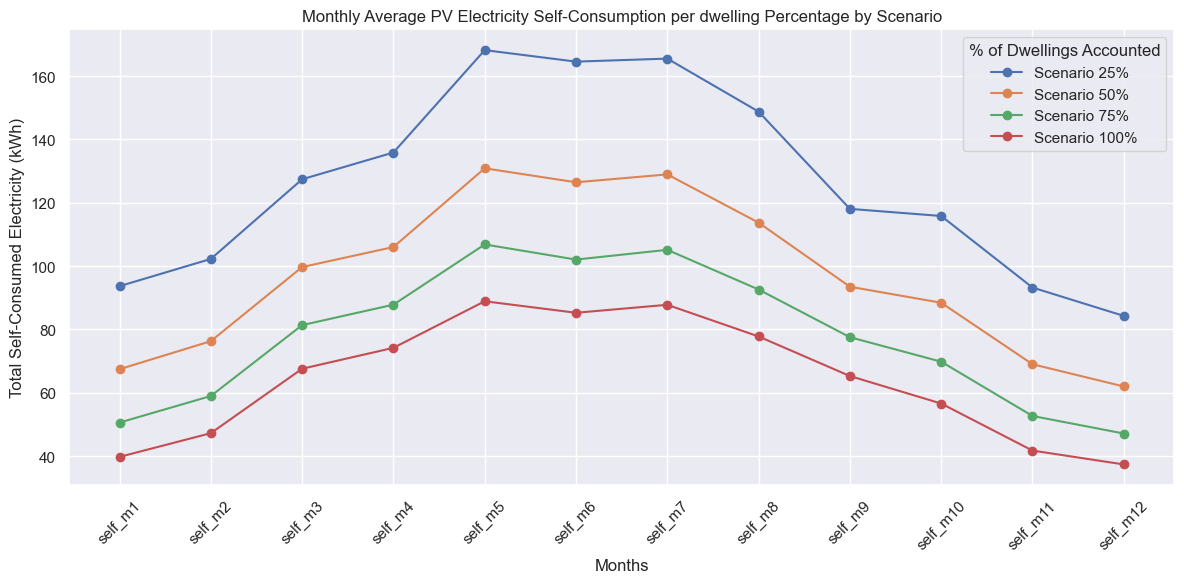

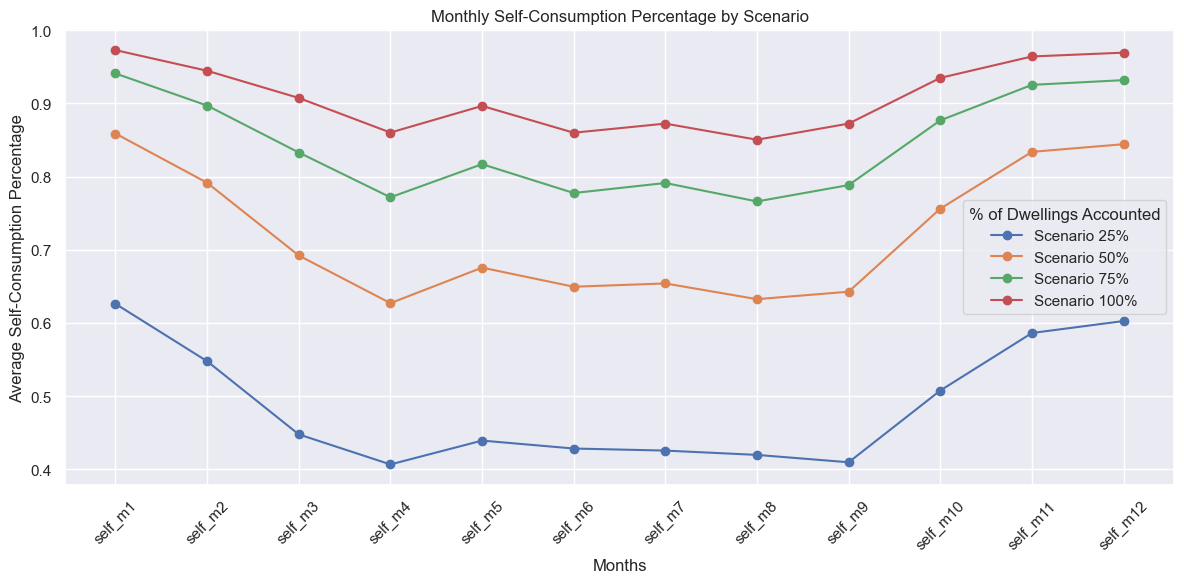

04_aggreg_cons_prof_with_pv_by_census_id_monthly_0.25.csv  :  0.25
04_aggreg_cons_prof_with_pv_by_census_id_monthly_0.5.csv  :  0.5
04_aggreg_cons_prof_with_pv_by_census_id_monthly_0.75.csv  :  0.75
04_aggreg_cons_prof_with_pv_by_census_id_monthly_1.csv  :  1


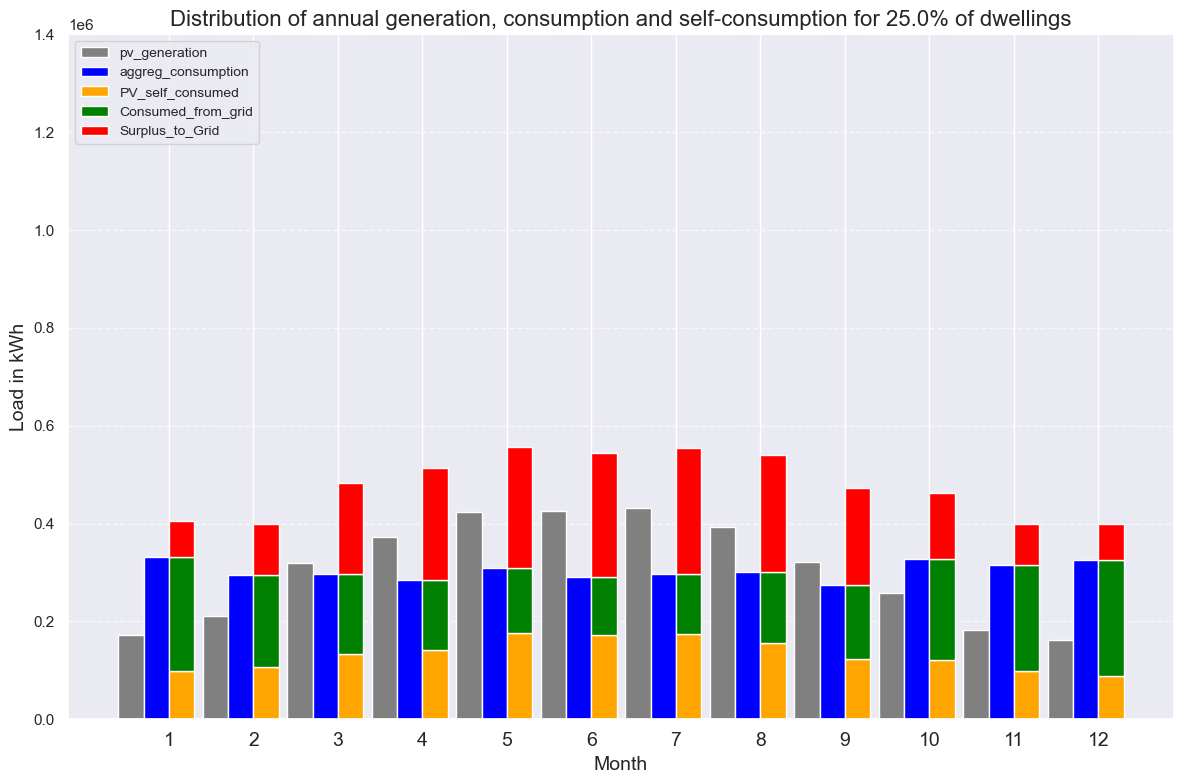

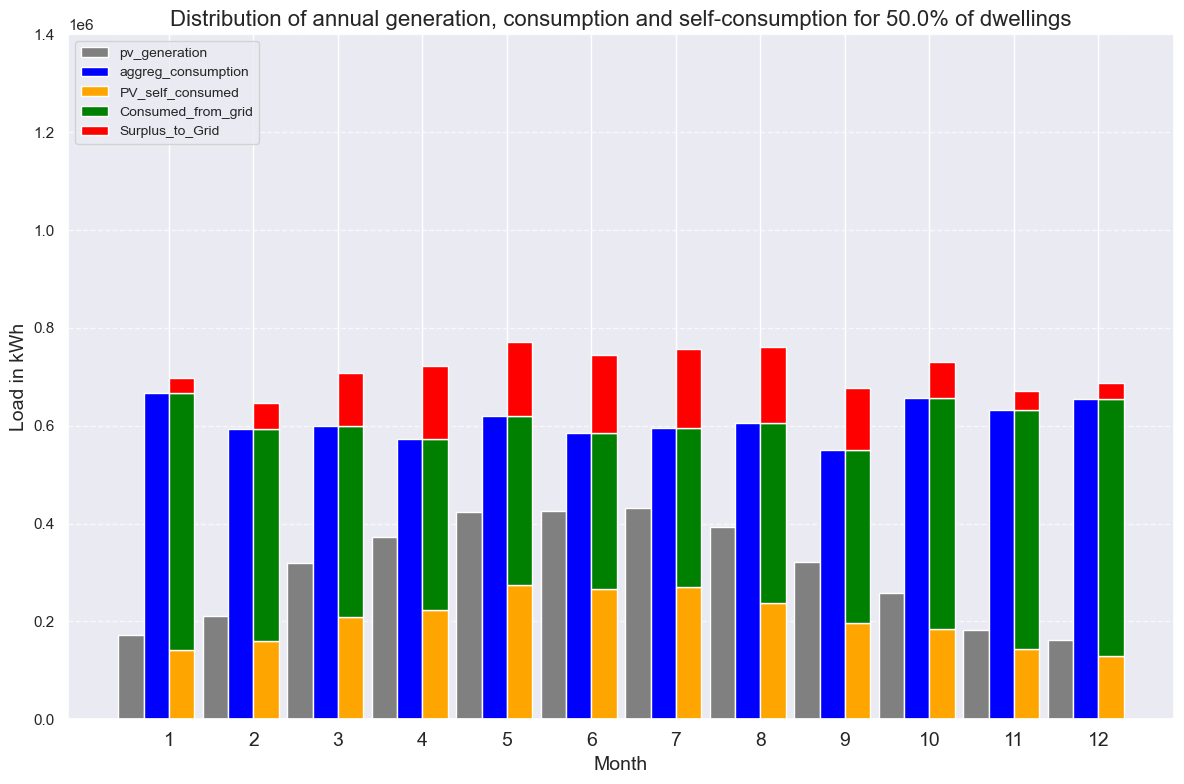

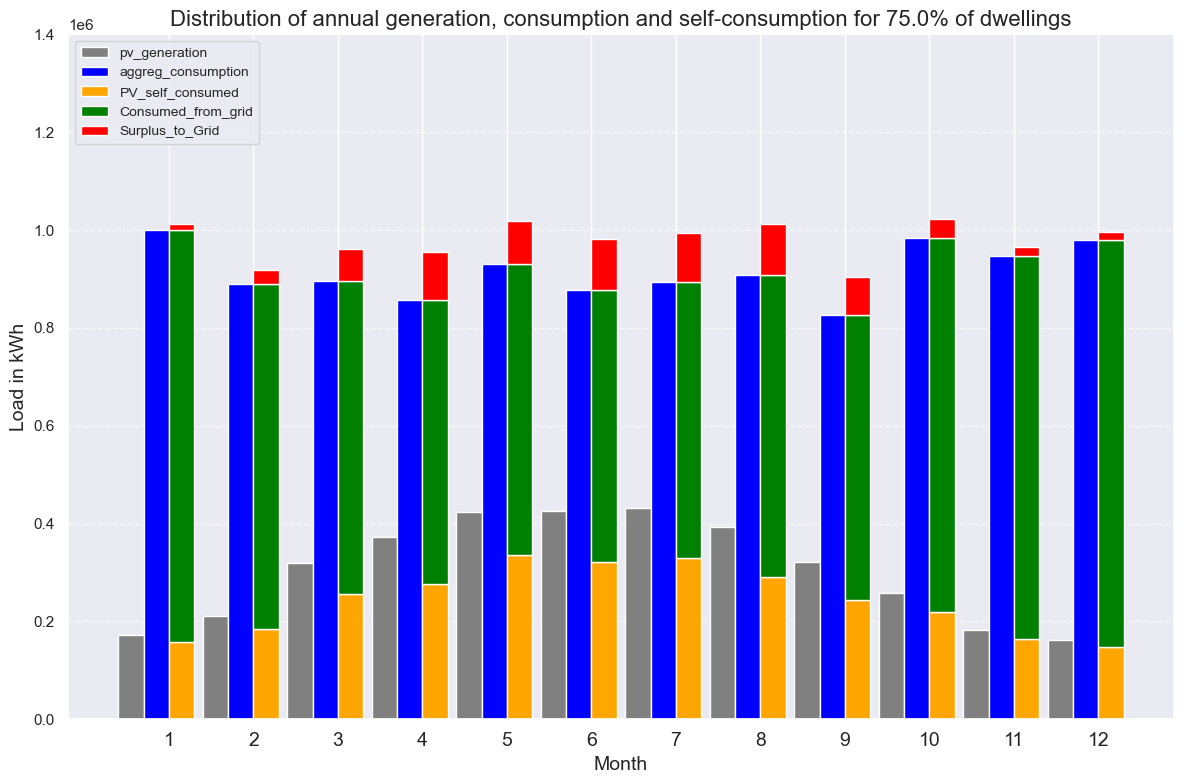

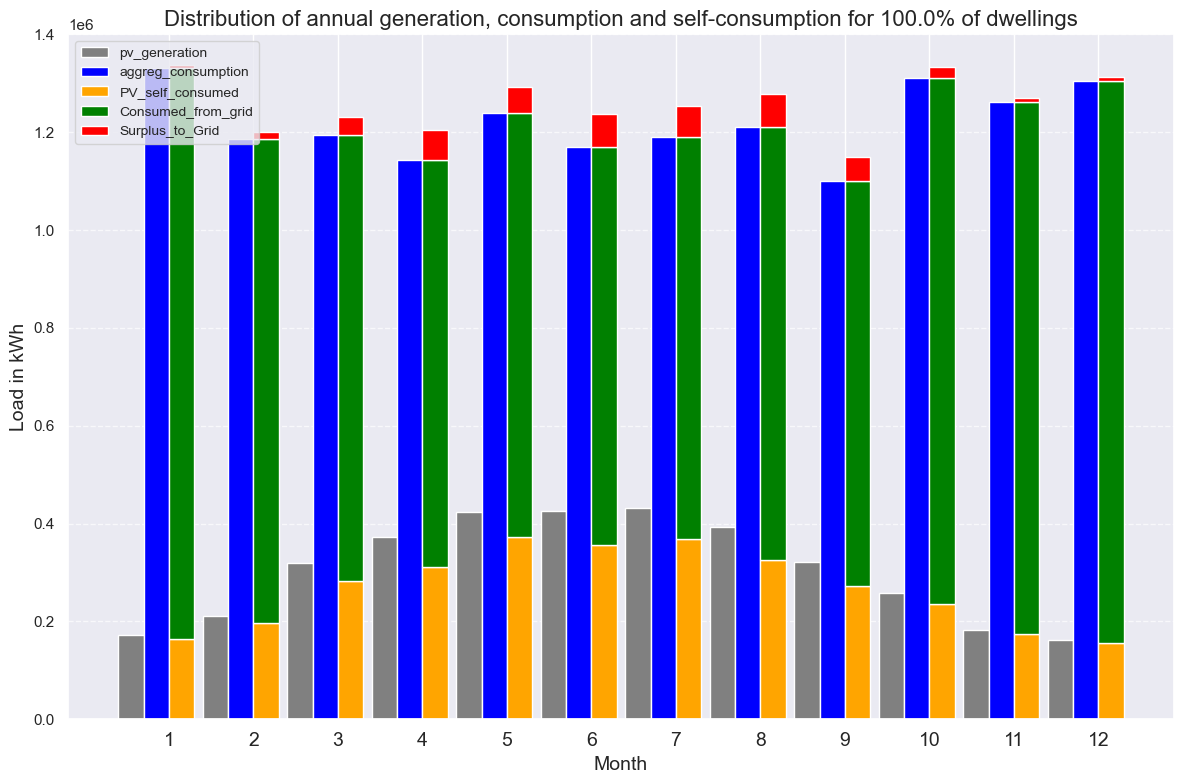

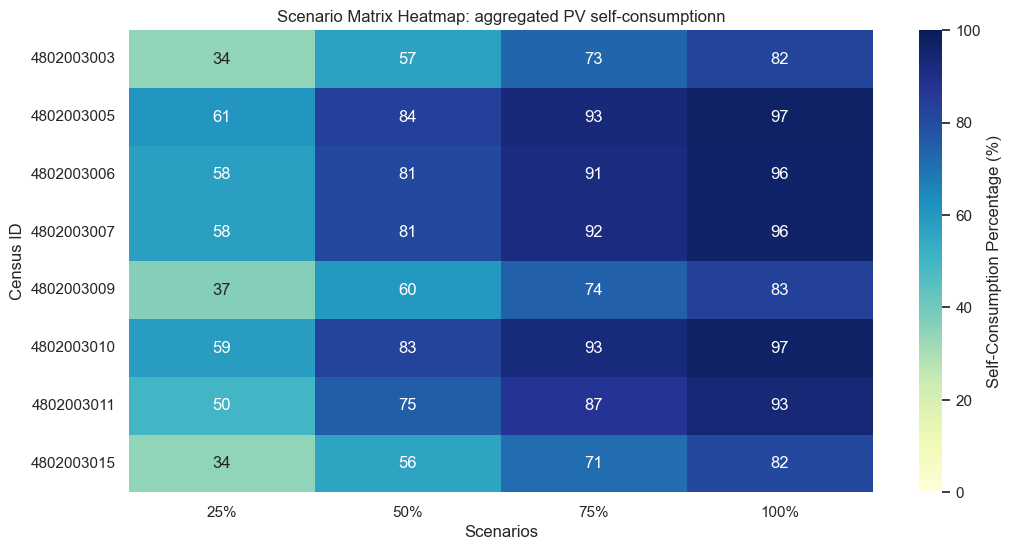

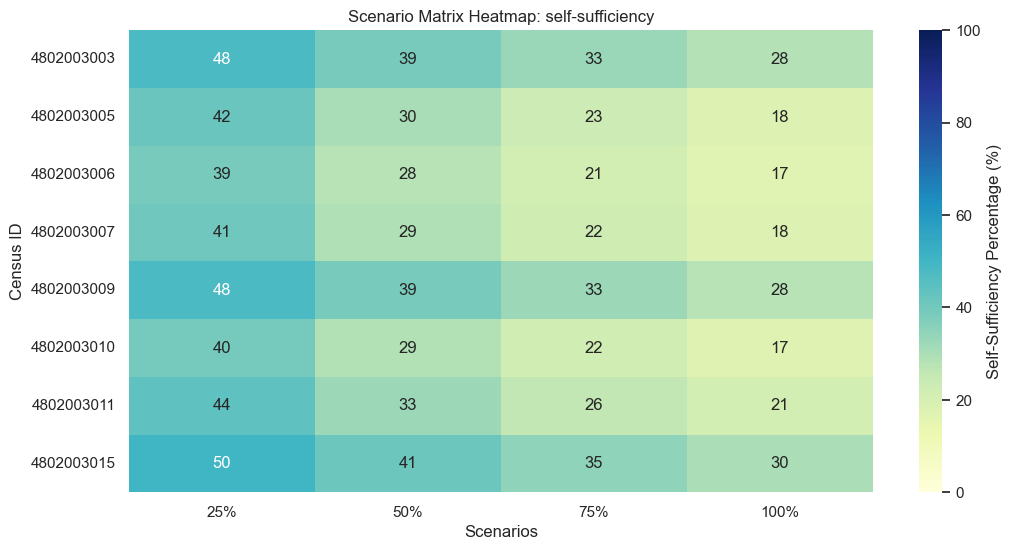

In [40]:
self_cons_analysis = self_cons_scenarios_calc.SelfConsumptionAnalysis(PATH, df_pv_gen_filered)
self_cons_analysis.calculate_self_consumption()
self_cons_analysis.calculate_per_dwelling()


self_cons_analysis.load_consumption_data()
self_cons_analysis.filter_per_dwelling_percentage()
self_cons_analysis.create_heatmap()
self_cons_analysis.calculate_self_sufficiency()

#util_funct_plots = util_func.PlotFunctions()
#util_funct_plots.plot_combined_load_data_from_df_adj(df_plot, title, legend_show=True, y_min=None, y_max=None)

#### 07_geo_visualization

The code of this class provides geospatial visualization tools for energy and economic indicators at the census section level. It merges census geometries with building or scenario data and generates heatmaps for metrics such as energy demand, CO₂ emissions, non-renewable primary energy (NRPE), and economic costs (EUAC). 

The visualizations support scenario comparison and spatial analysis of building retrofit and PV impacts across districts.

In [ ]:
census_file = os.path.join(os.getcwd(), "vector", "stat_census", default_paths.get("STATISTICAL_CENSUS_FILE"))
data_file = os.path.join(os.getcwd(), "data", "05_buildings_with_energy_and_co2_values+HDemProj_facade_costs+PV_economic+EUAC_ORIGIN.xlsx")

# Pass the desired filter value as an argument
visualizer = geo_visualization.GeoHeatmapVisualizer(census_file, data_file, filter_value='Comb0ref_case', sheet_name=sheet_name)
visualizer.plot_energy_co2_heatmaps()
visualizer.geo_heatmap(column_1='NRPE_Envelope_kWh_per_m2', column_2='Envelope_EUAC_per_m2', vmin1=0, vmax1=200, vmin2=0, vmax2=50)
visualizer.geo_heatmap_no_colorbar(column_1='NRPE_kWh_per_dwelling', column_2='EUAC_per_dwelling')

## MODULE 6
#### 06_enercom_estimator
This script estimates and compares annual and monthly energy costs for residential energy communities under different PV adoption rates and electricity pricing scenarios.

- it aggregates PV generation and consumption data by census area;
- calculates self-consumption, grid export, and cost savings for both PV and non-PV households; and
- performs sensitivity analysis on price and participation rates.

Results are exported to Excel and visualized with bar plots to support scenario analysis and policy evaluation.

Root directory: c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework
PV generation data loaded from and grouped by census_id.


c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:37: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  self.df_pv_gen = self.df_pv_gen.groupby('census_id').sum().reset_index()


dwelling_by_residents_num


c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:128: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.energy_data[f'gen_surpl_dir_m{i}'] = self.energy_data[gen_col] - self.energy_data[f'load_cov_dir_m{i}']
c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:129: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.energy_data[f'load_resid_dir_m{i}'] = self.energy_data[cons_col] - self.energy_data[f'load_cov_dir_m{i}']
c:\Users\Oleksandr-M

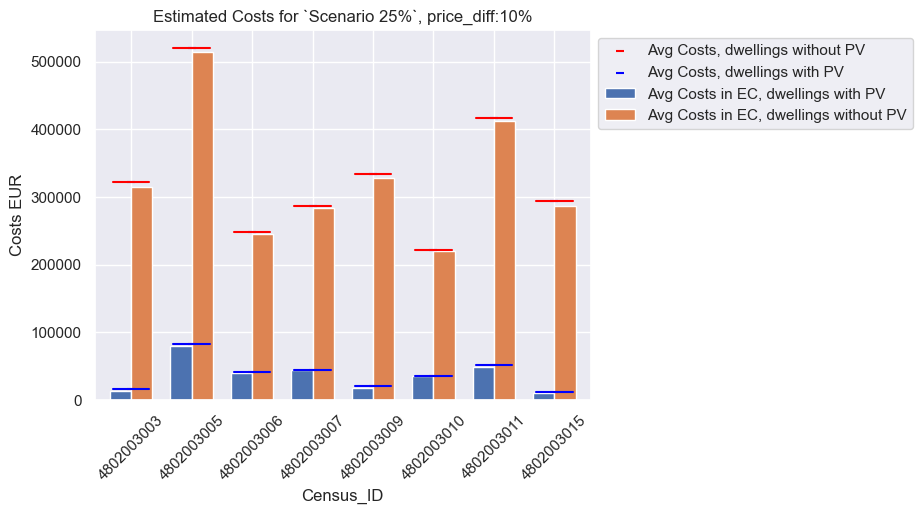

c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:286: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df_sensitivity_total = self.df_sensitivity_total.append(df_total_cost)


<Figure size 640x480 with 0 Axes>

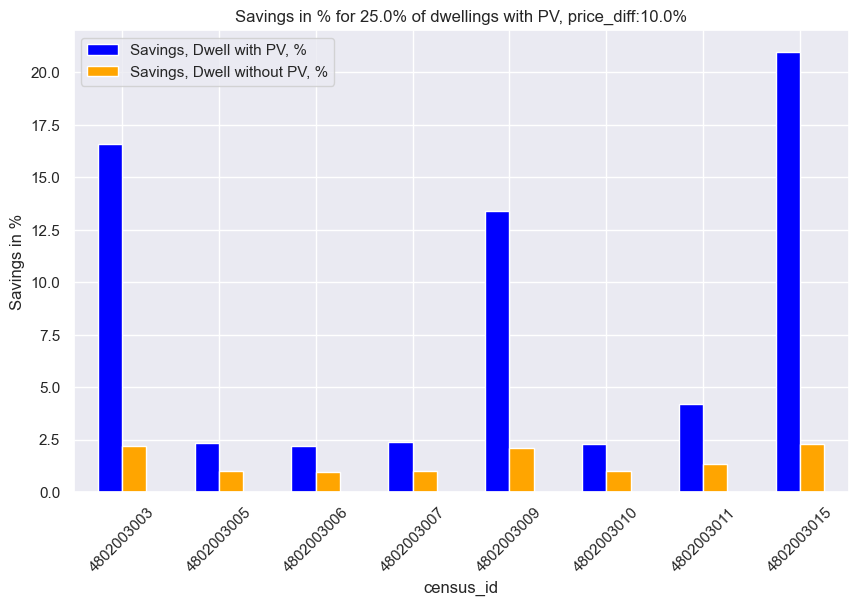

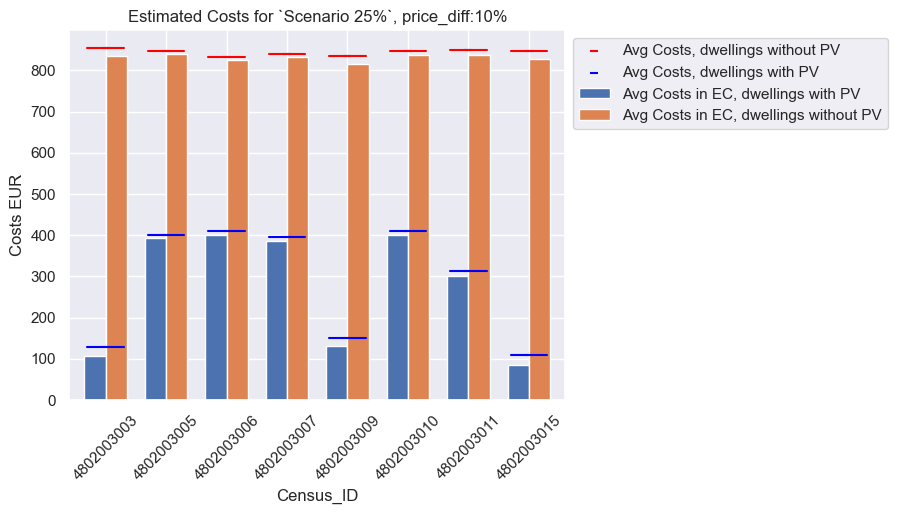

C:\Users\Oleksandr-MSI\AppData\Local\Temp\ipykernel_3016\364270464.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sensitivity_append = df_sensitivity_append.append(df_estimator)
c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:37: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  self.df_pv_gen = self.df_pv_gen.groupby('census_id').sum().reset_index()


Root directory: c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework
PV generation data loaded from and grouped by census_id.
dwelling_by_residents_num


c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:128: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.energy_data[f'gen_surpl_dir_m{i}'] = self.energy_data[gen_col] - self.energy_data[f'load_cov_dir_m{i}']
c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:129: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.energy_data[f'load_resid_dir_m{i}'] = self.energy_data[cons_col] - self.energy_data[f'load_cov_dir_m{i}']
c:\Users\Oleksandr-M

<Figure size 640x480 with 0 Axes>

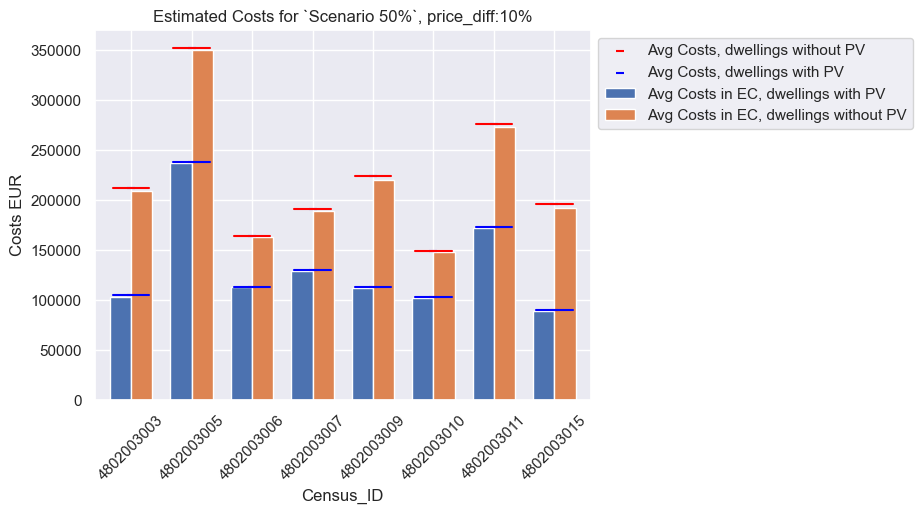

c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:286: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df_sensitivity_total = self.df_sensitivity_total.append(df_total_cost)


<Figure size 640x480 with 0 Axes>

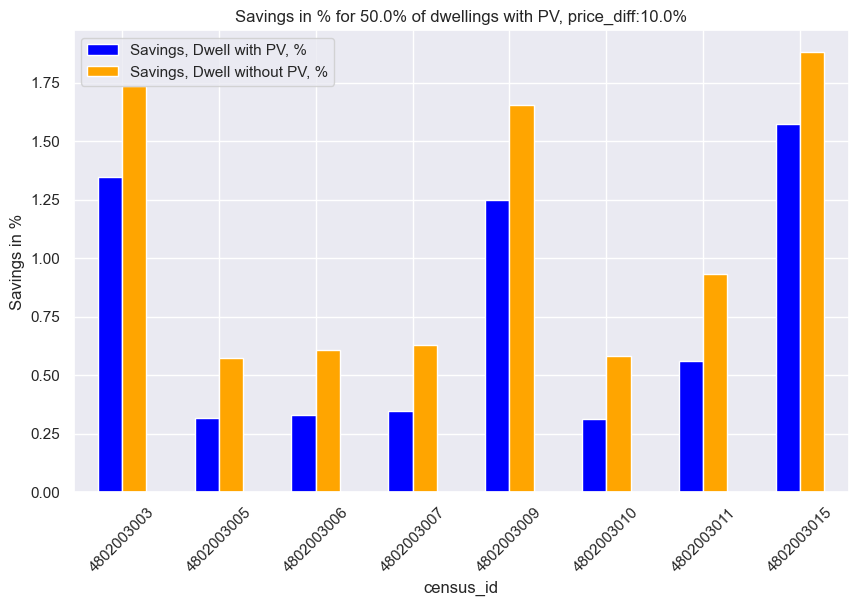

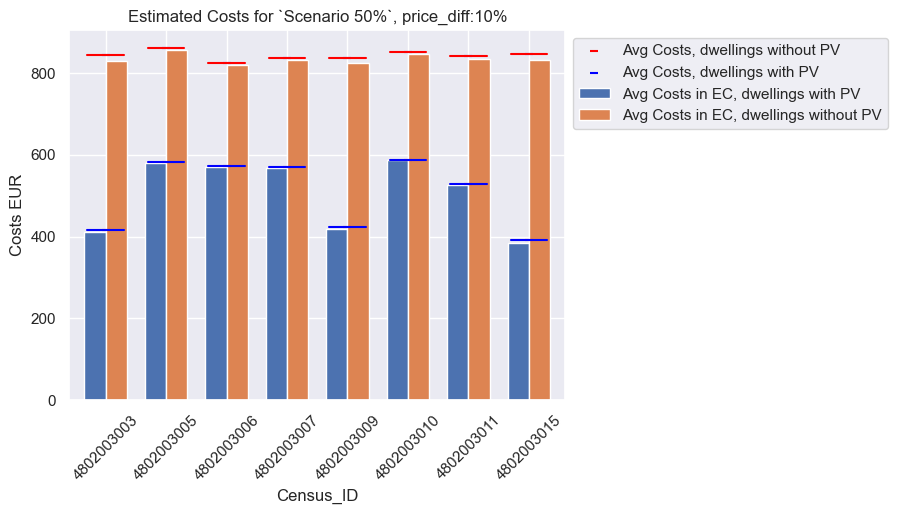

C:\Users\Oleksandr-MSI\AppData\Local\Temp\ipykernel_3016\364270464.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sensitivity_append = df_sensitivity_append.append(df_estimator)
c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:37: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  self.df_pv_gen = self.df_pv_gen.groupby('census_id').sum().reset_index()


Root directory: c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework
PV generation data loaded from and grouped by census_id.
dwelling_by_residents_num


c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:128: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.energy_data[f'gen_surpl_dir_m{i}'] = self.energy_data[gen_col] - self.energy_data[f'load_cov_dir_m{i}']
c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:129: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.energy_data[f'load_resid_dir_m{i}'] = self.energy_data[cons_col] - self.energy_data[f'load_cov_dir_m{i}']
c:\Users\Oleksandr-M

<Figure size 640x480 with 0 Axes>

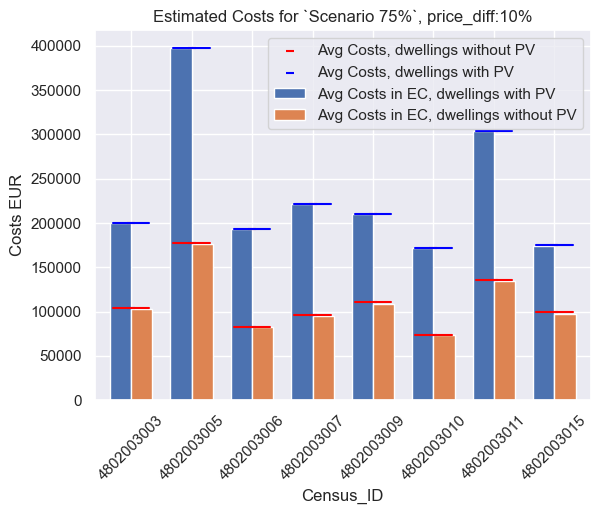

c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:286: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df_sensitivity_total = self.df_sensitivity_total.append(df_total_cost)


<Figure size 640x480 with 0 Axes>

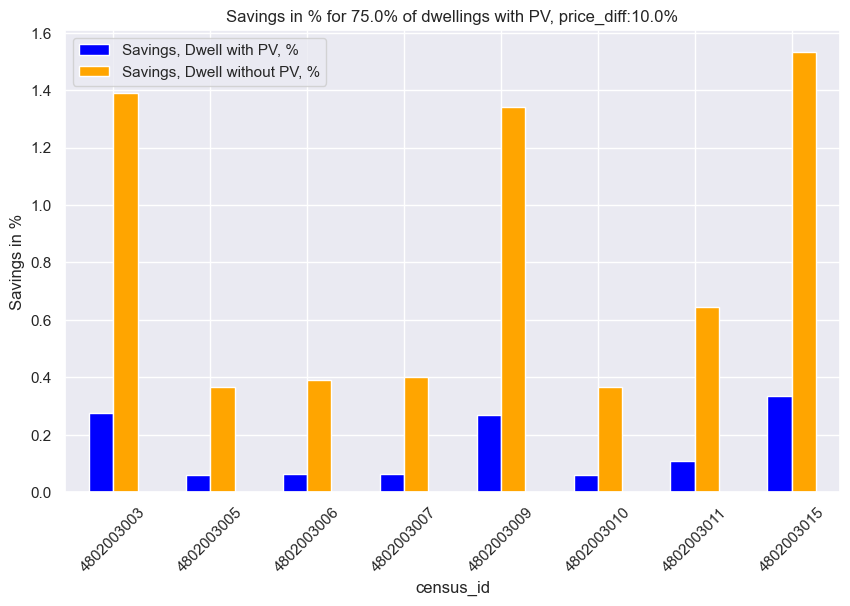

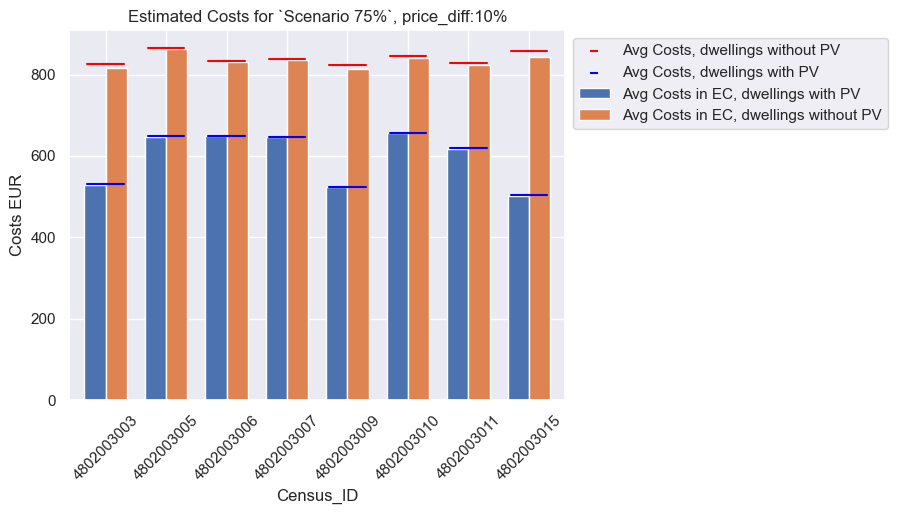

C:\Users\Oleksandr-MSI\AppData\Local\Temp\ipykernel_3016\364270464.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sensitivity_append = df_sensitivity_append.append(df_estimator)
c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:37: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  self.df_pv_gen = self.df_pv_gen.groupby('census_id').sum().reset_index()


Root directory: c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework
PV generation data loaded from and grouped by census_id.
dwelling_by_residents_num


c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:128: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.energy_data[f'gen_surpl_dir_m{i}'] = self.energy_data[gen_col] - self.energy_data[f'load_cov_dir_m{i}']
c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:129: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.energy_data[f'load_resid_dir_m{i}'] = self.energy_data[cons_col] - self.energy_data[f'load_cov_dir_m{i}']
c:\Users\Oleksandr-M

<Figure size 640x480 with 0 Axes>

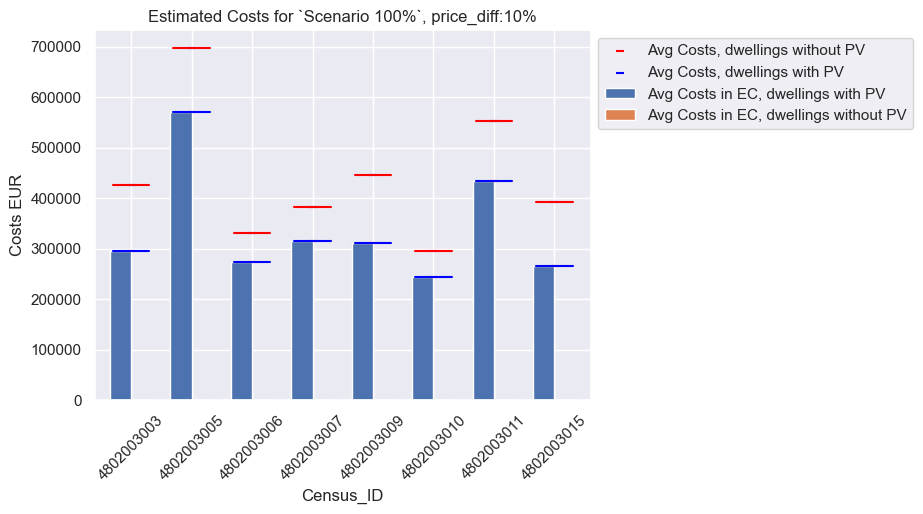

c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:286: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df_sensitivity_total = self.df_sensitivity_total.append(df_total_cost)


<Figure size 640x480 with 0 Axes>

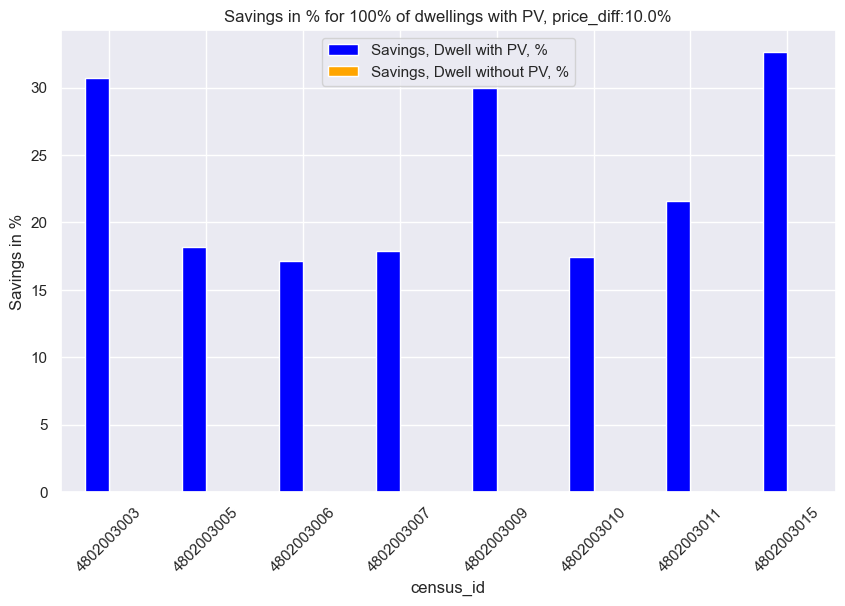

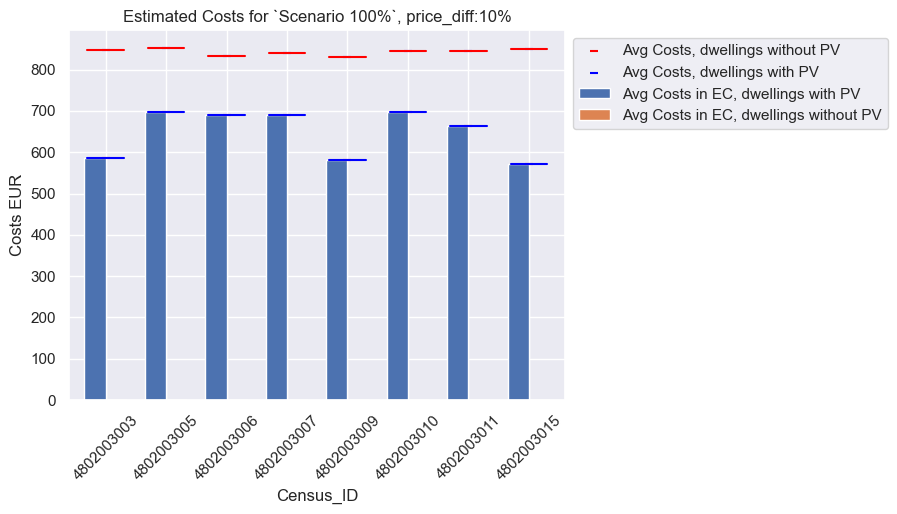

C:\Users\Oleksandr-MSI\AppData\Local\Temp\ipykernel_3016\364270464.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sensitivity_append = df_sensitivity_append.append(df_estimator)
c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:37: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  self.df_pv_gen = self.df_pv_gen.groupby('census_id').sum().reset_index()


Root directory: c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework
PV generation data loaded from and grouped by census_id.
dwelling_by_residents_num


c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:128: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.energy_data[f'gen_surpl_dir_m{i}'] = self.energy_data[gen_col] - self.energy_data[f'load_cov_dir_m{i}']
c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:129: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.energy_data[f'load_resid_dir_m{i}'] = self.energy_data[cons_col] - self.energy_data[f'load_cov_dir_m{i}']
c:\Users\Oleksandr-M

<Figure size 640x480 with 0 Axes>

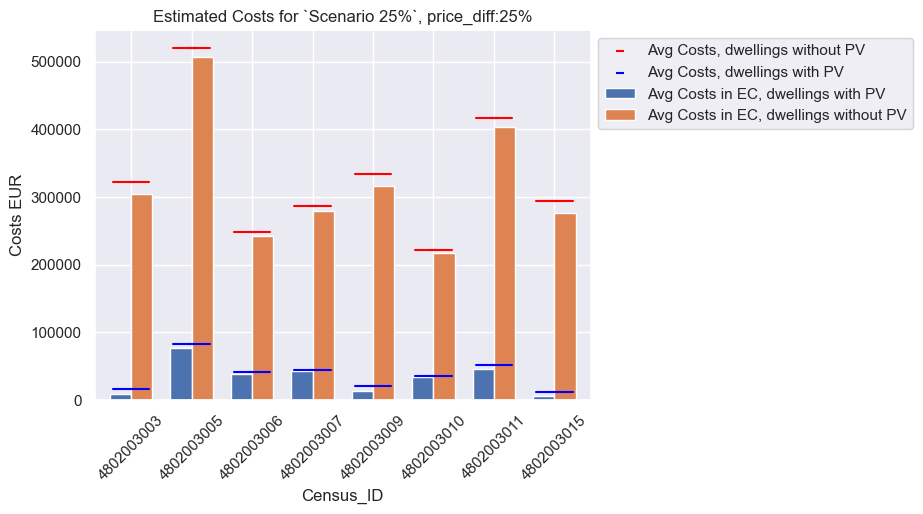

c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:286: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df_sensitivity_total = self.df_sensitivity_total.append(df_total_cost)


<Figure size 640x480 with 0 Axes>

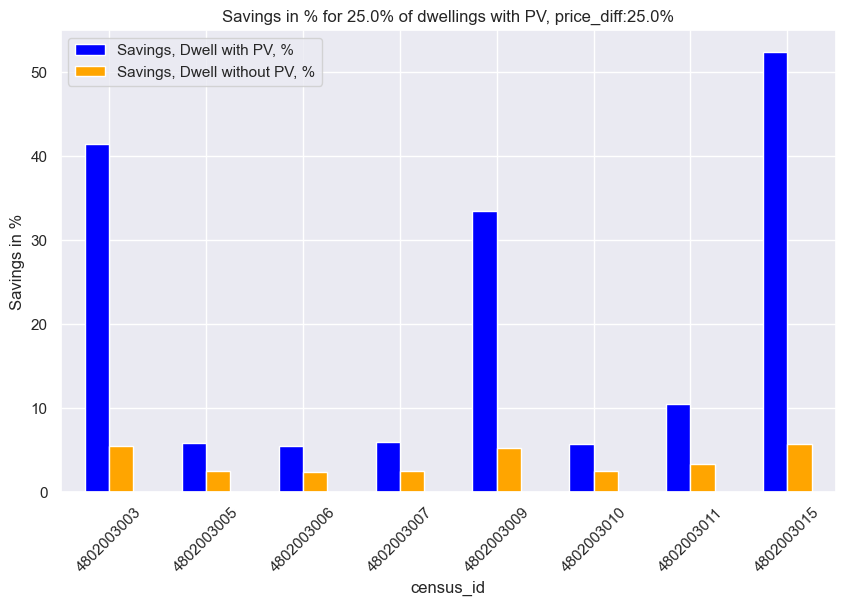

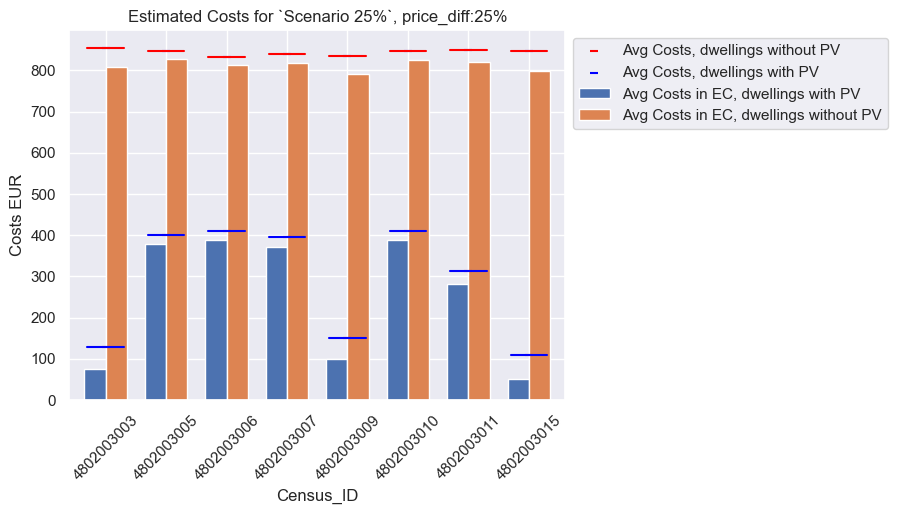

C:\Users\Oleksandr-MSI\AppData\Local\Temp\ipykernel_3016\364270464.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sensitivity_append = df_sensitivity_append.append(df_estimator)
c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:37: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  self.df_pv_gen = self.df_pv_gen.groupby('census_id').sum().reset_index()


Root directory: c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework
PV generation data loaded from and grouped by census_id.
dwelling_by_residents_num


c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:128: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.energy_data[f'gen_surpl_dir_m{i}'] = self.energy_data[gen_col] - self.energy_data[f'load_cov_dir_m{i}']
c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:129: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.energy_data[f'load_resid_dir_m{i}'] = self.energy_data[cons_col] - self.energy_data[f'load_cov_dir_m{i}']
c:\Users\Oleksandr-M

<Figure size 640x480 with 0 Axes>

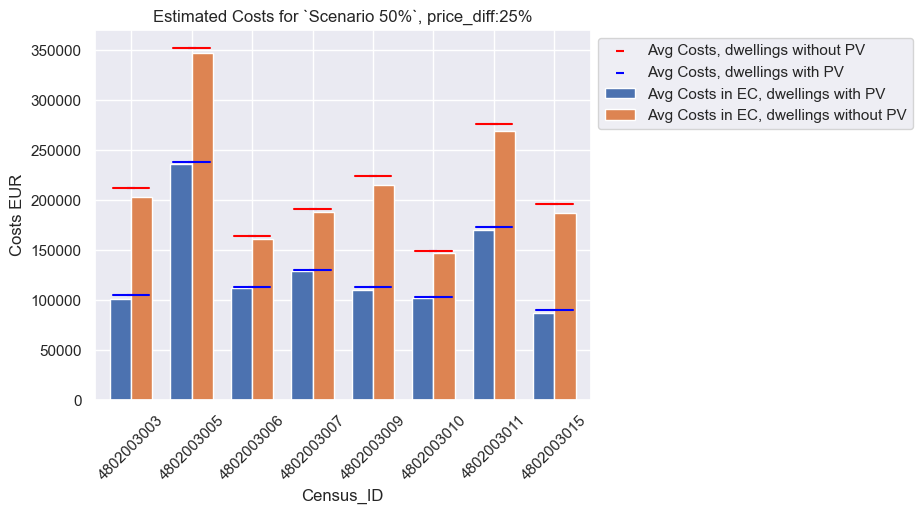

c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:286: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df_sensitivity_total = self.df_sensitivity_total.append(df_total_cost)


<Figure size 640x480 with 0 Axes>

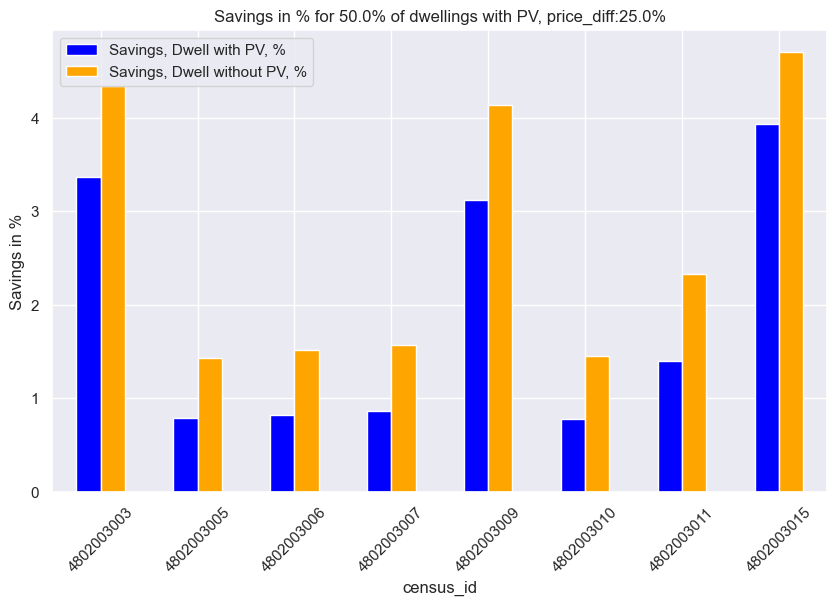

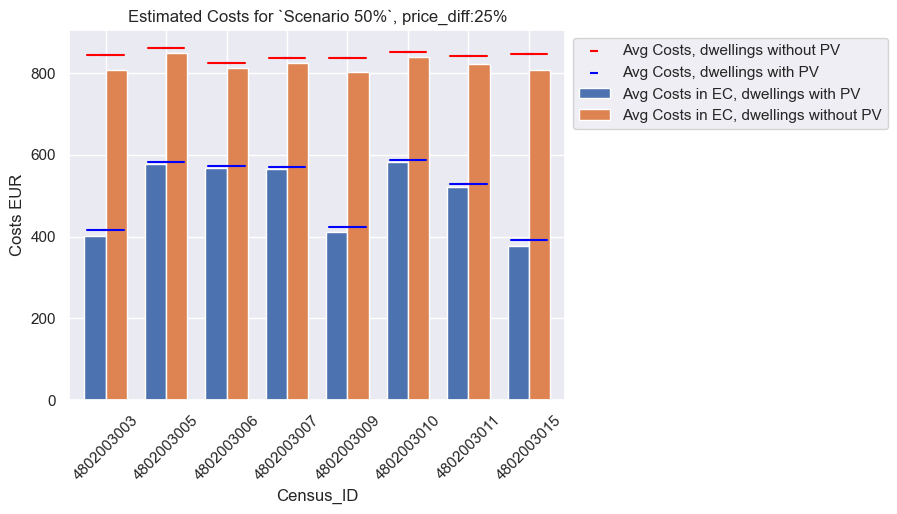

C:\Users\Oleksandr-MSI\AppData\Local\Temp\ipykernel_3016\364270464.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sensitivity_append = df_sensitivity_append.append(df_estimator)
c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:37: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  self.df_pv_gen = self.df_pv_gen.groupby('census_id').sum().reset_index()


Root directory: c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework
PV generation data loaded from and grouped by census_id.
dwelling_by_residents_num


c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:128: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.energy_data[f'gen_surpl_dir_m{i}'] = self.energy_data[gen_col] - self.energy_data[f'load_cov_dir_m{i}']
c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:129: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.energy_data[f'load_resid_dir_m{i}'] = self.energy_data[cons_col] - self.energy_data[f'load_cov_dir_m{i}']
c:\Users\Oleksandr-M

<Figure size 640x480 with 0 Axes>

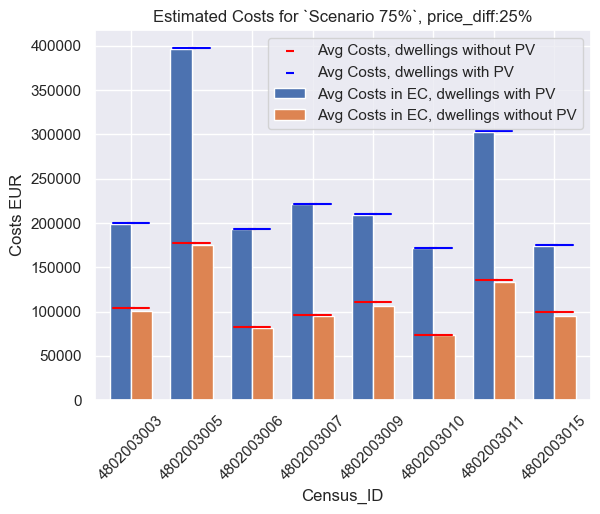

c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:286: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df_sensitivity_total = self.df_sensitivity_total.append(df_total_cost)


<Figure size 640x480 with 0 Axes>

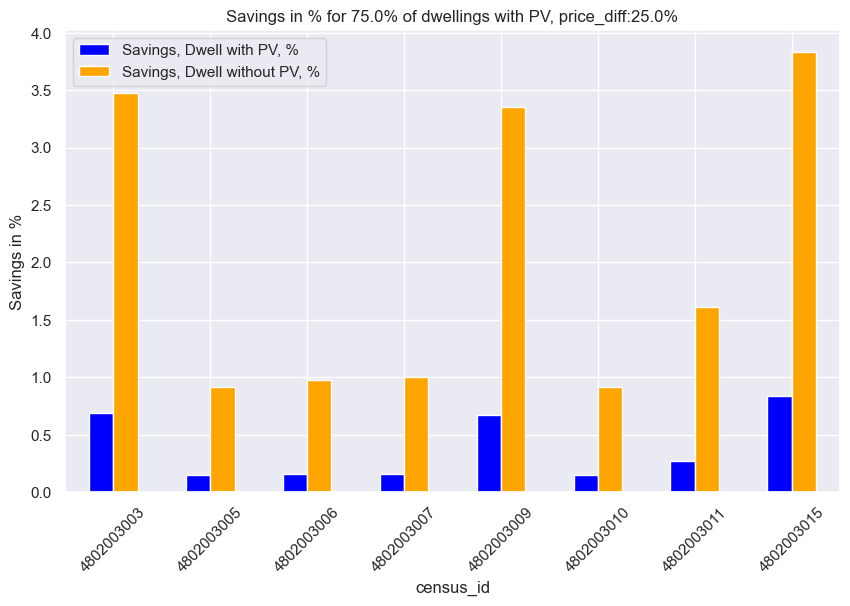

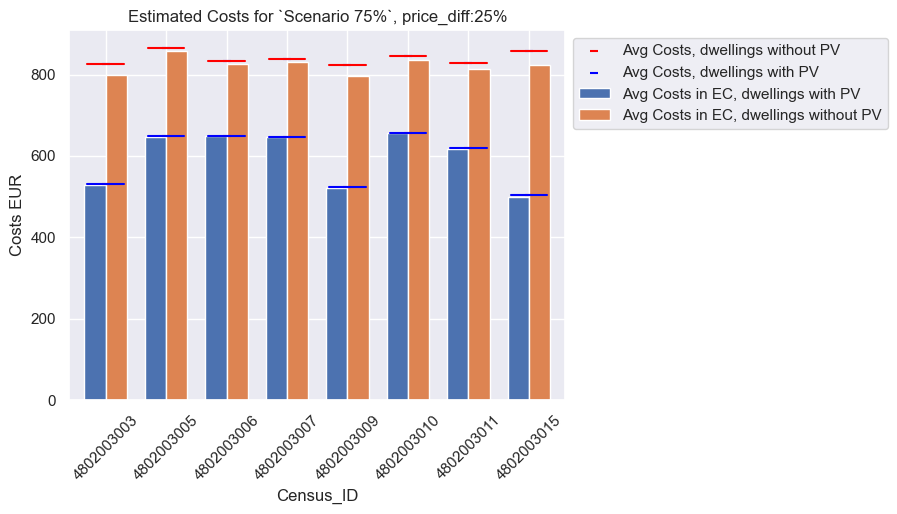

C:\Users\Oleksandr-MSI\AppData\Local\Temp\ipykernel_3016\364270464.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sensitivity_append = df_sensitivity_append.append(df_estimator)
c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:37: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  self.df_pv_gen = self.df_pv_gen.groupby('census_id').sum().reset_index()


Root directory: c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework
PV generation data loaded from and grouped by census_id.
dwelling_by_residents_num


c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:128: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.energy_data[f'gen_surpl_dir_m{i}'] = self.energy_data[gen_col] - self.energy_data[f'load_cov_dir_m{i}']
c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:129: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.energy_data[f'load_resid_dir_m{i}'] = self.energy_data[cons_col] - self.energy_data[f'load_cov_dir_m{i}']
c:\Users\Oleksandr-M

<Figure size 640x480 with 0 Axes>

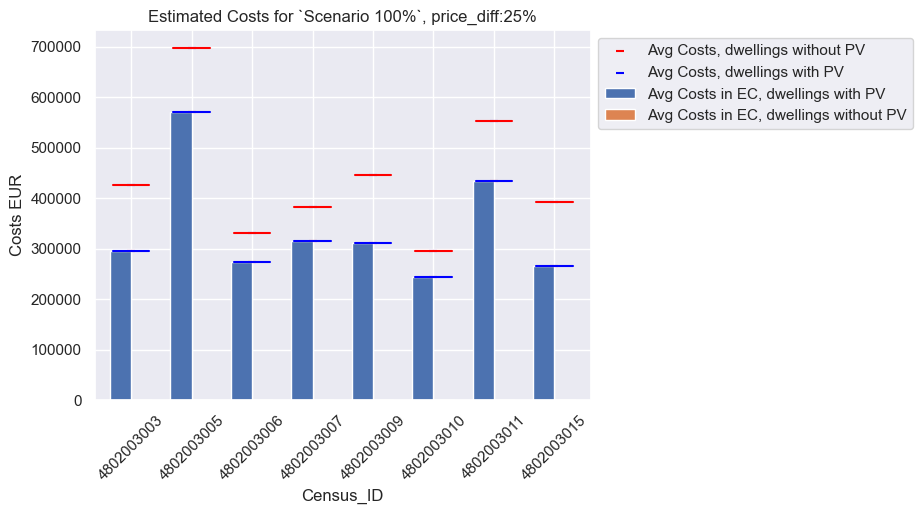

c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:286: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df_sensitivity_total = self.df_sensitivity_total.append(df_total_cost)


<Figure size 640x480 with 0 Axes>

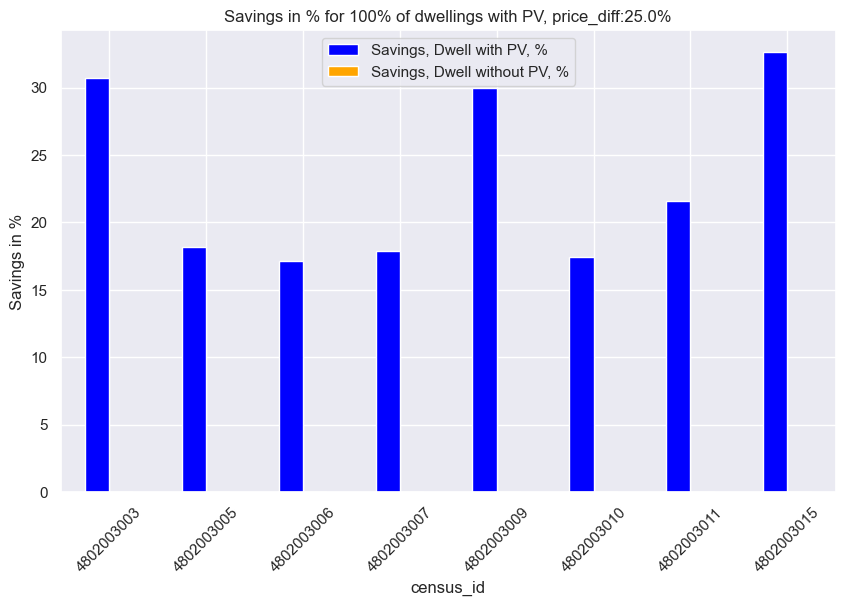

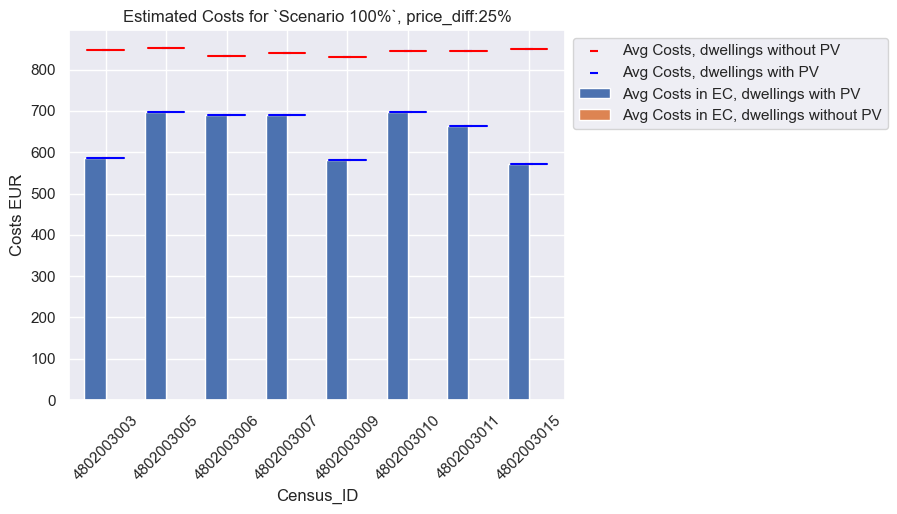

C:\Users\Oleksandr-MSI\AppData\Local\Temp\ipykernel_3016\364270464.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sensitivity_append = df_sensitivity_append.append(df_estimator)
c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:37: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  self.df_pv_gen = self.df_pv_gen.groupby('census_id').sum().reset_index()


Root directory: c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework
PV generation data loaded from and grouped by census_id.
dwelling_by_residents_num


c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:128: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.energy_data[f'gen_surpl_dir_m{i}'] = self.energy_data[gen_col] - self.energy_data[f'load_cov_dir_m{i}']
c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:129: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.energy_data[f'load_resid_dir_m{i}'] = self.energy_data[cons_col] - self.energy_data[f'load_cov_dir_m{i}']
c:\Users\Oleksandr-M

<Figure size 640x480 with 0 Axes>

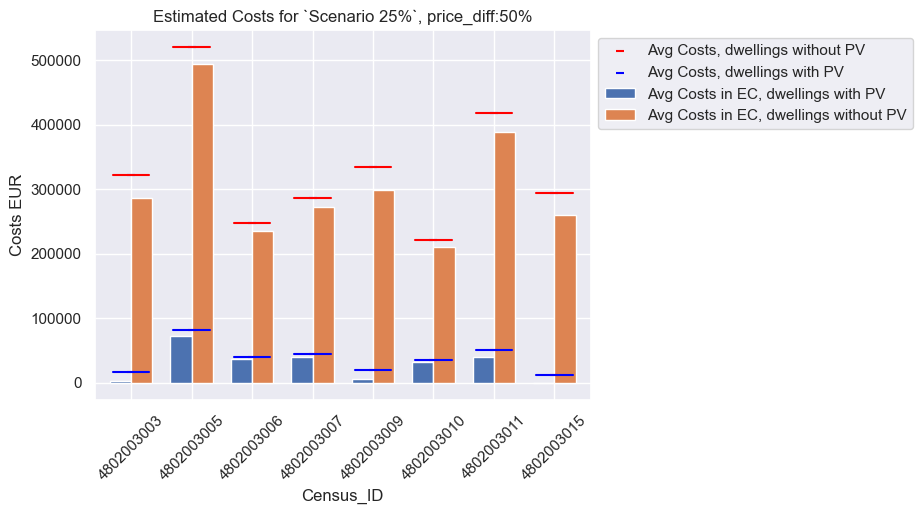

c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:286: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df_sensitivity_total = self.df_sensitivity_total.append(df_total_cost)


<Figure size 640x480 with 0 Axes>

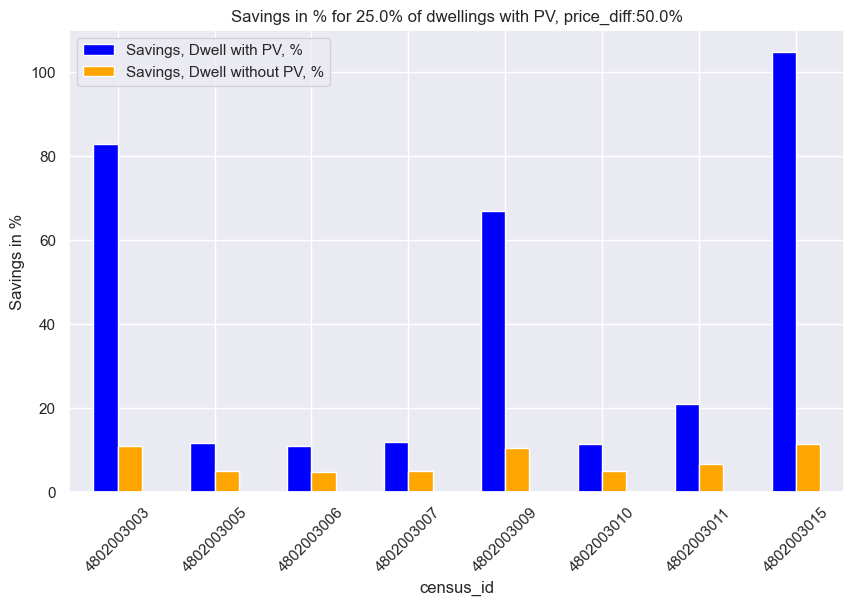

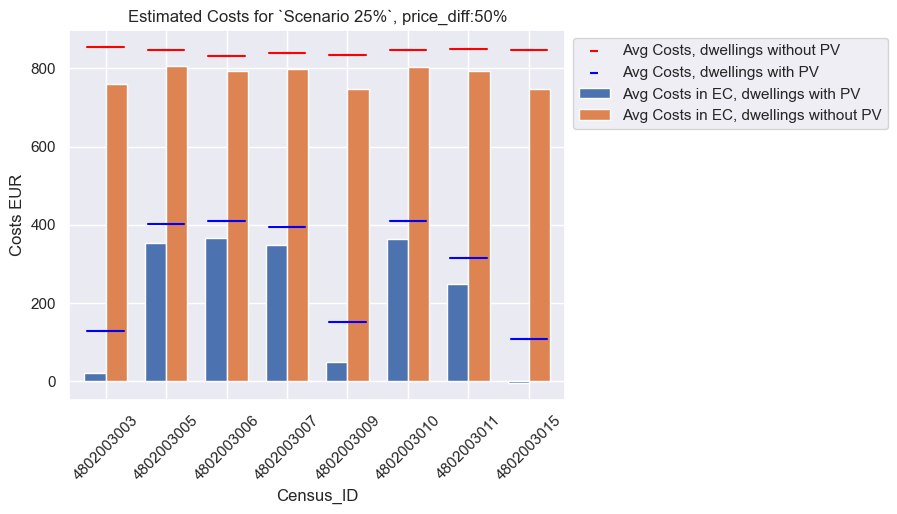

C:\Users\Oleksandr-MSI\AppData\Local\Temp\ipykernel_3016\364270464.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sensitivity_append = df_sensitivity_append.append(df_estimator)
c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:37: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  self.df_pv_gen = self.df_pv_gen.groupby('census_id').sum().reset_index()


Root directory: c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework
PV generation data loaded from and grouped by census_id.
dwelling_by_residents_num


c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:128: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.energy_data[f'gen_surpl_dir_m{i}'] = self.energy_data[gen_col] - self.energy_data[f'load_cov_dir_m{i}']
c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:129: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.energy_data[f'load_resid_dir_m{i}'] = self.energy_data[cons_col] - self.energy_data[f'load_cov_dir_m{i}']
c:\Users\Oleksandr-M

<Figure size 640x480 with 0 Axes>

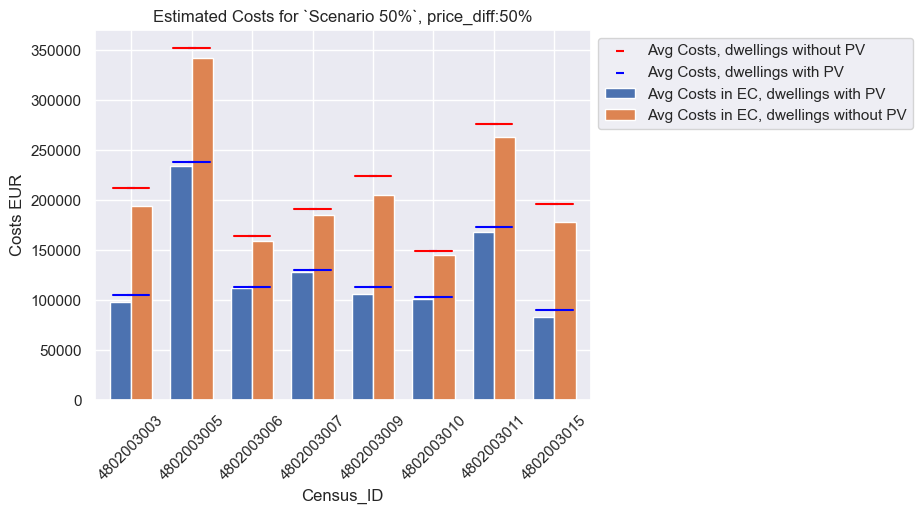

c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:286: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df_sensitivity_total = self.df_sensitivity_total.append(df_total_cost)


<Figure size 640x480 with 0 Axes>

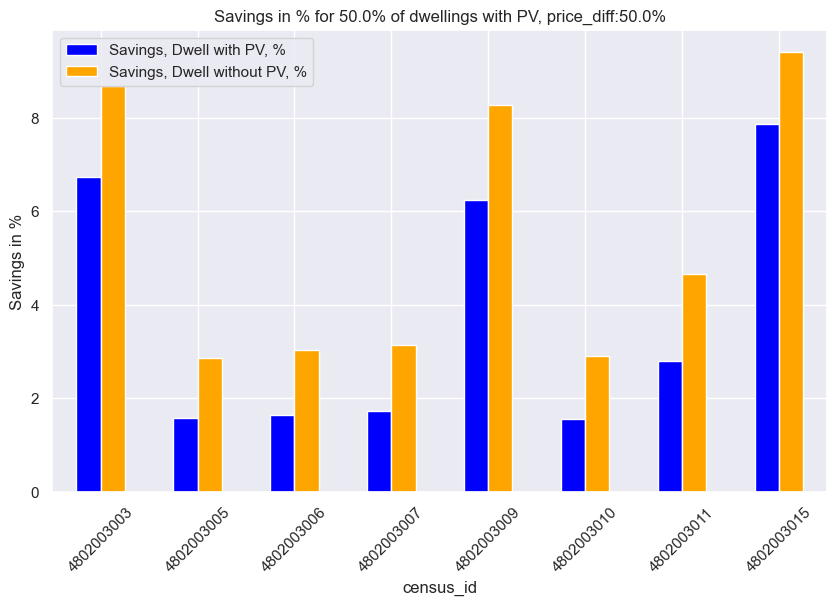

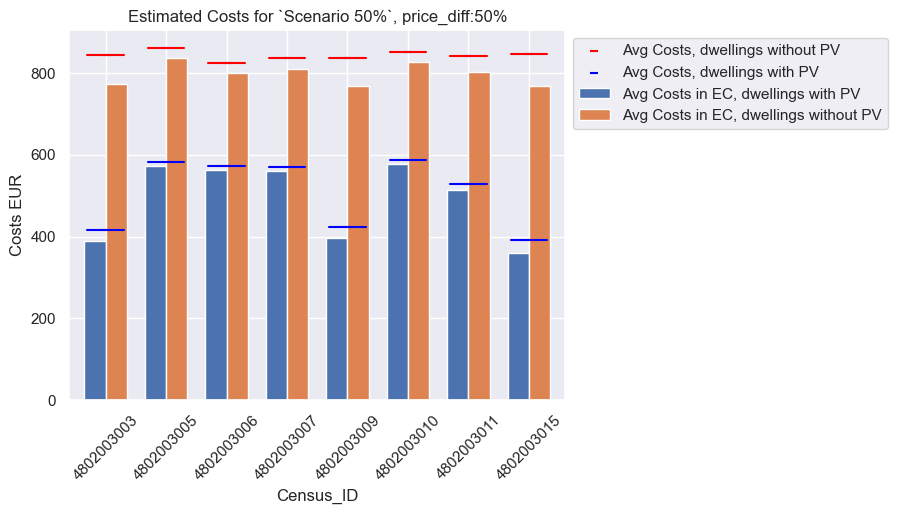

C:\Users\Oleksandr-MSI\AppData\Local\Temp\ipykernel_3016\364270464.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sensitivity_append = df_sensitivity_append.append(df_estimator)
c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:37: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  self.df_pv_gen = self.df_pv_gen.groupby('census_id').sum().reset_index()


Root directory: c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework
PV generation data loaded from and grouped by census_id.
dwelling_by_residents_num


c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:128: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.energy_data[f'gen_surpl_dir_m{i}'] = self.energy_data[gen_col] - self.energy_data[f'load_cov_dir_m{i}']
c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:129: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.energy_data[f'load_resid_dir_m{i}'] = self.energy_data[cons_col] - self.energy_data[f'load_cov_dir_m{i}']
c:\Users\Oleksandr-M

<Figure size 640x480 with 0 Axes>

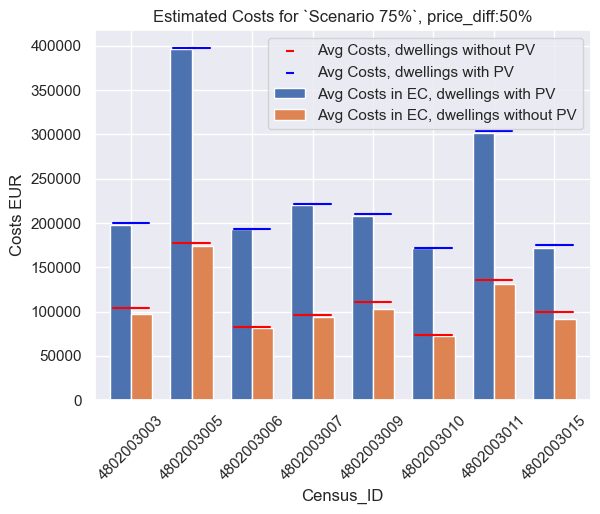

c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:286: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df_sensitivity_total = self.df_sensitivity_total.append(df_total_cost)


<Figure size 640x480 with 0 Axes>

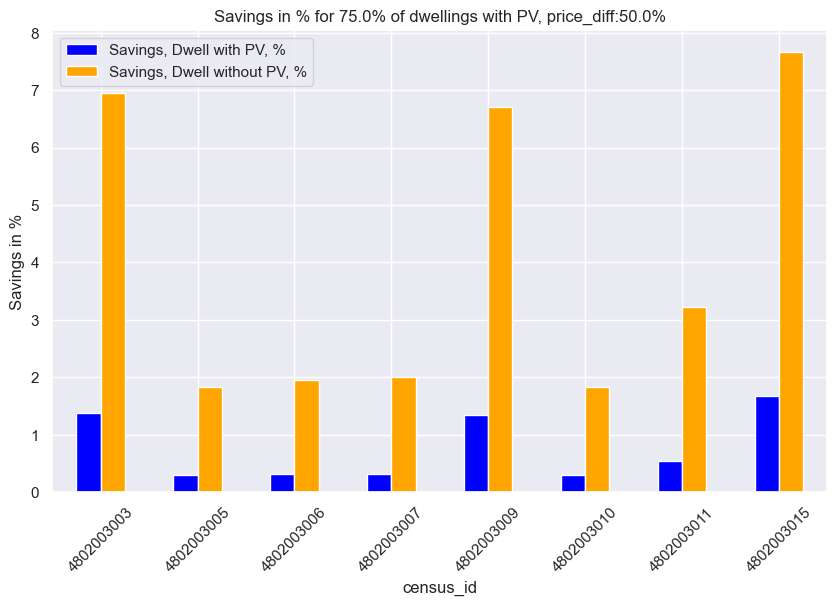

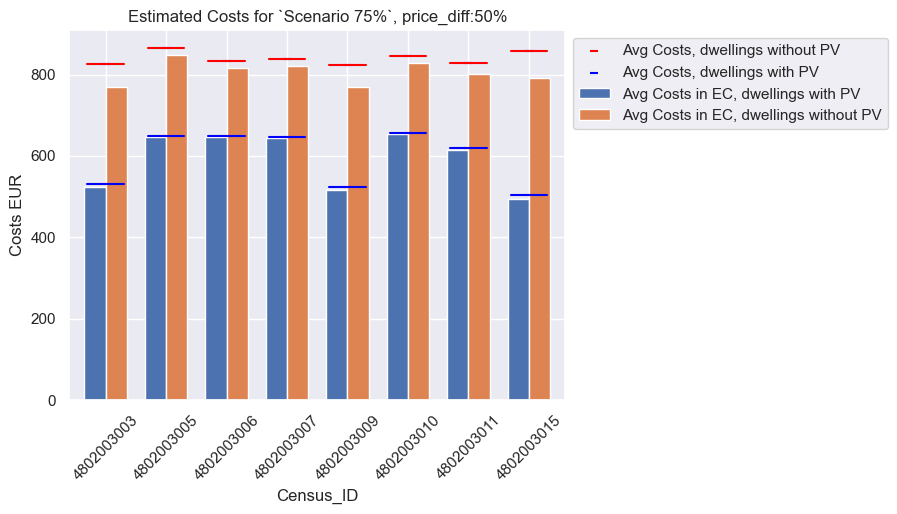

C:\Users\Oleksandr-MSI\AppData\Local\Temp\ipykernel_3016\364270464.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sensitivity_append = df_sensitivity_append.append(df_estimator)
c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:37: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  self.df_pv_gen = self.df_pv_gen.groupby('census_id').sum().reset_index()


Root directory: c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework
PV generation data loaded from and grouped by census_id.
dwelling_by_residents_num


c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:128: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.energy_data[f'gen_surpl_dir_m{i}'] = self.energy_data[gen_col] - self.energy_data[f'load_cov_dir_m{i}']
c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:129: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.energy_data[f'load_resid_dir_m{i}'] = self.energy_data[cons_col] - self.energy_data[f'load_cov_dir_m{i}']
c:\Users\Oleksandr-M

<Figure size 640x480 with 0 Axes>

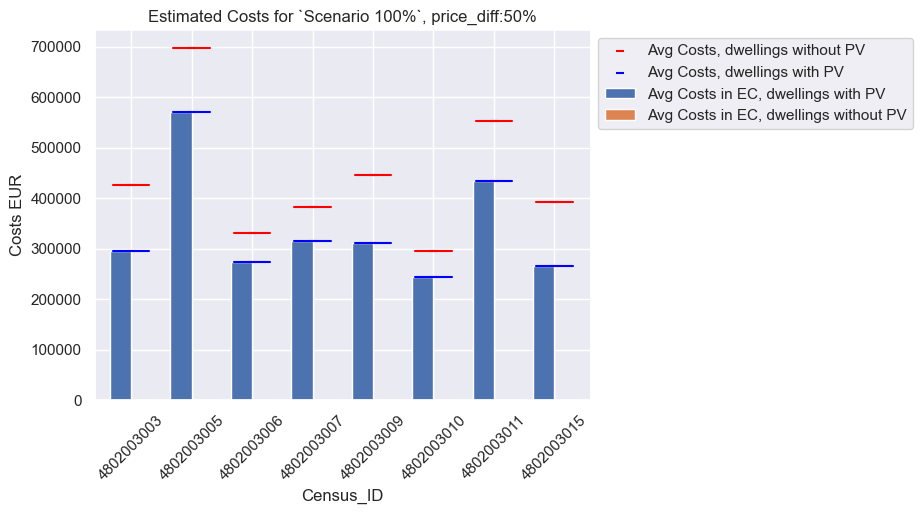

c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:286: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df_sensitivity_total = self.df_sensitivity_total.append(df_total_cost)


<Figure size 640x480 with 0 Axes>

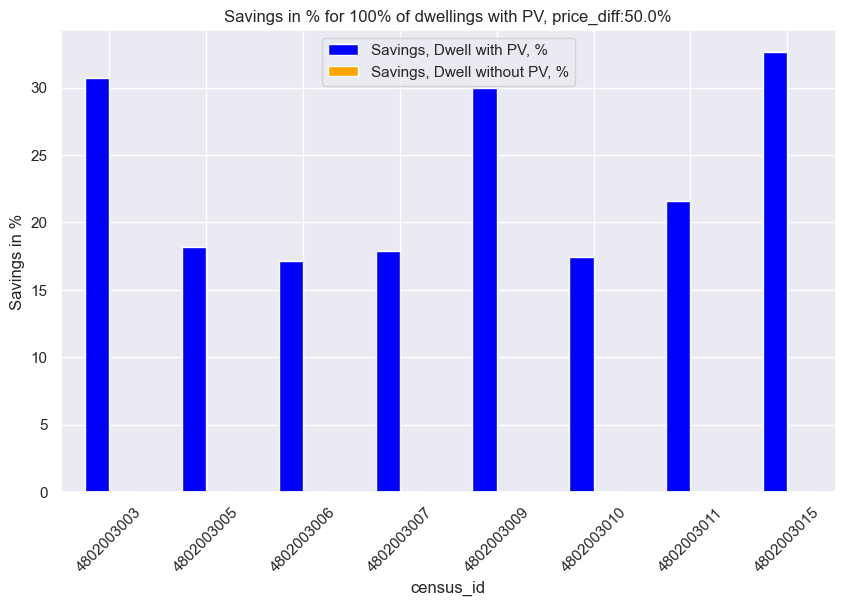

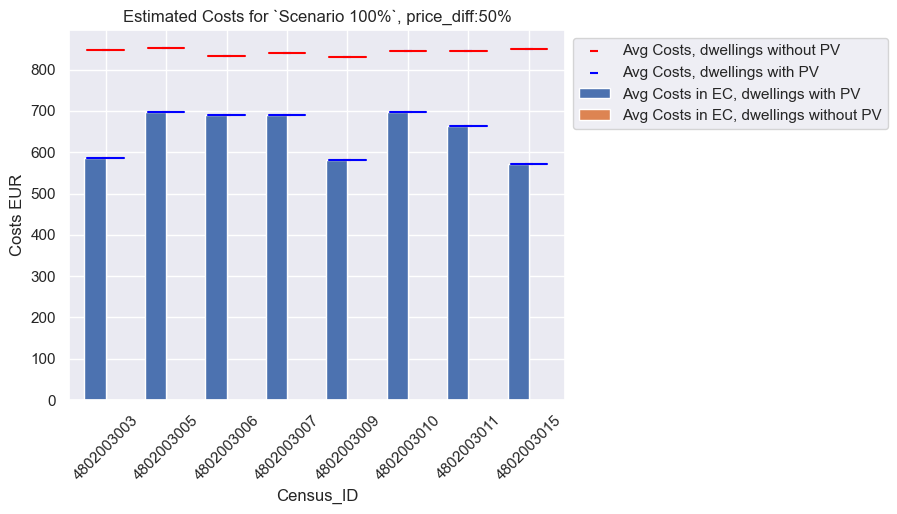

C:\Users\Oleksandr-MSI\AppData\Local\Temp\ipykernel_3016\364270464.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sensitivity_append = df_sensitivity_append.append(df_estimator)


<Figure size 640x480 with 0 Axes>

In [41]:
df_sensitivity_append = pd.DataFrame()

#ec_price_coef_list = [0.1, 0.25]
#pv_pct_list = [0.25, 0.5, 1] # List of dwellings % participate in EC as theoretical direct collective PV self-consumption
for ec_price_coef in ec_price_coef_list:
    for pv_pct in pv_pct_list:
        estimator = enercom_estimator.EnercomEstimator(root=PATH, 
                                                       df_pv_gen=df_pv_gen_filered,
                                                       pv_pct=pv_pct,
                                                       ec_price_coef=ec_price_coef
                                                       )
        estimator.prepare_energy_data()
        estimator.calculate_costs()
        estimator.export_to_excel()
        df_estimator = estimator.analyze(plot =True, title=f"Estimated Costs for `Scenario {int(pv_pct * 100)}%`, price_diff:{int(ec_price_coef * 100)}%")
        estimator.plot_saving(df_estimator)
        estimator.monthly_sensitivity_analysis()
        estimator.save_sensitivity()
        df_sensitivity_append = df_sensitivity_append.append(df_estimator)
         
estimator.save_sensitivity(df_sensitivity_append)

### Sensitivity Plot

Percentage of energy cost savings per scenario and share of associated with collective (direct) PV self-consumption in the census zone


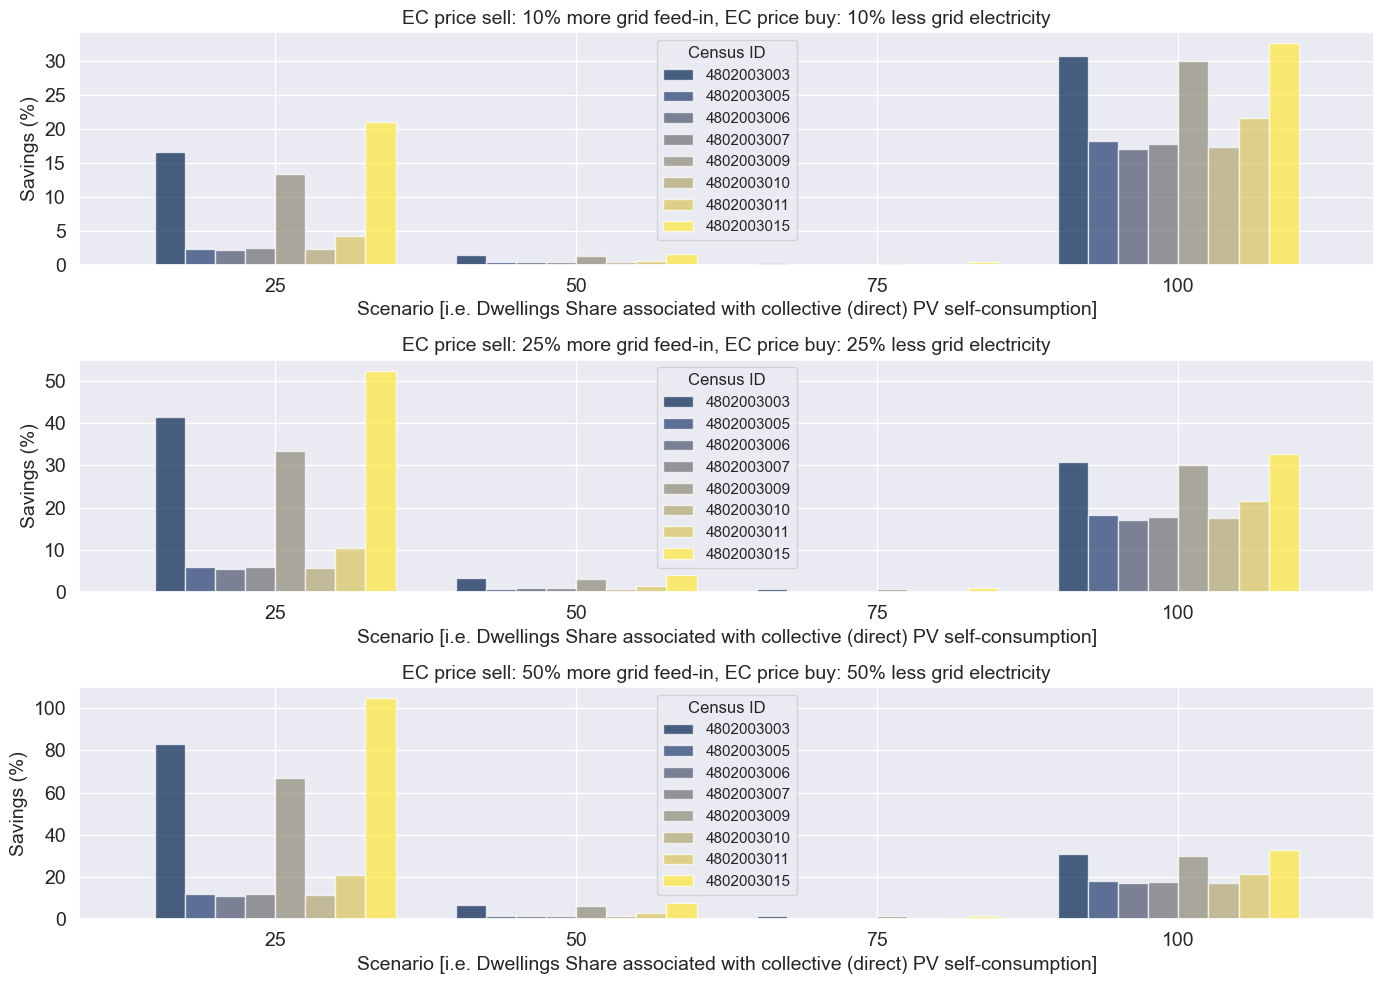

Percentage of energy cost savings per scenario and share of dwellings not associated with collective (direct) PV self-consumption in the census zone


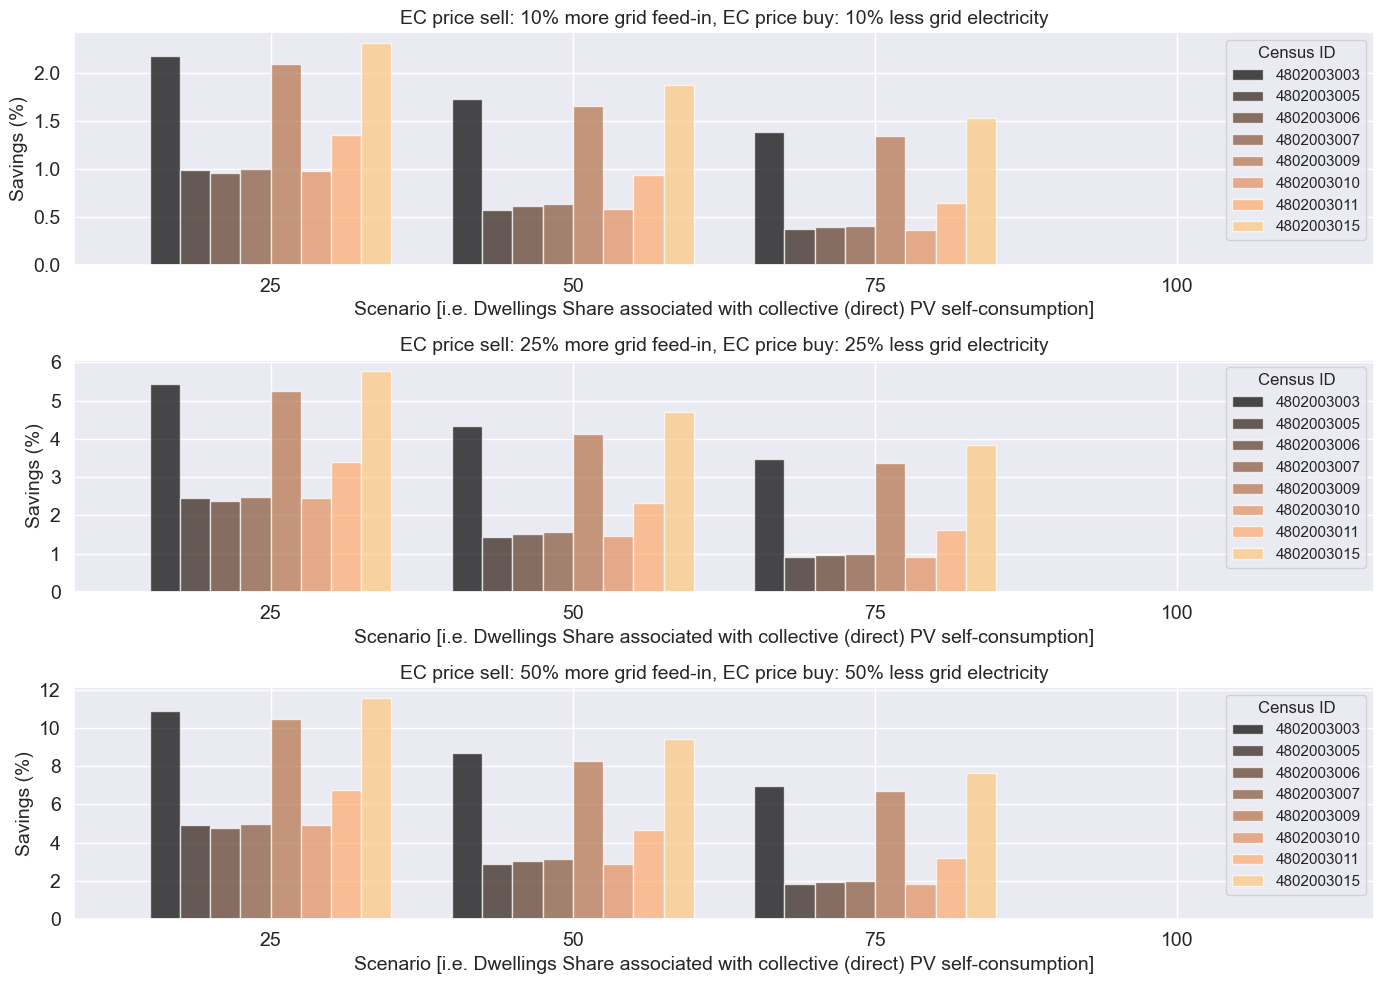

In [42]:
df = df_sensitivity_append.reset_index()
print ("Percentage of energy cost savings per scenario and share of associated with collective (direct) PV self-consumption in the census zone")
estimator.plot_savings_distribution(df,values = "Savings, Dwell with PV, %", colormap='cividis')
print ("Percentage of energy cost savings per scenario and share of dwellings not associated with collective (direct) PV self-consumption in the census zone")
estimator.plot_savings_distribution(df,values = "Savings, Dwell without PV, %", colormap='copper')